## 0. Imports

In [1]:
seed = 0

In [2]:
import inspect
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import torch
from IPython.display import HTML

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
CURRENT_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURRENT_DIR)
sys.path.insert(0, PARENT_DIR)
sys.path.insert(0, os.path.join(PARENT_DIR, 'cpflow'))
sys.path.insert(0, os.path.join(PARENT_DIR, 'moses'))

from src.callbacks import MolCallback
from src.flow import GradFlow
from src.functionals import PotentialFunctional, SinkhornDivergenceFunctional, FunctionalSum
from src.models import LitVModel, MoleculeAnnotationPredictor
from moses.model import VAE, set_seed
set_seed(seed)

No POT
tsnecuda not found - will use (slower) cpu implementation


## 1. Load pretrained VAE and Convex surrogate models

In [4]:
# Load the VAE
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
vae_vocab = torch.load('../molecule_pde_files/vocab.pt')
vae_config = torch.load('../molecule_pde_files/config.pt')
vae = VAE(vae_vocab, vae_config)
vae_chkpt = torch.load('../molecule_pde_files/pretrained_vae.pt', map_location=device)
vae.load_state_dict(vae_chkpt)
vae.to(device)
vae.eval();

In [5]:
# Load the v_model
lit_v_model_chkpt = '../molecule_pde_files/pretrained_v_model.pt'

v_model = MoleculeAnnotationPredictor('ResICNN2', input_dim=128,
                                      hidden_dim=128, num_hidden_layers=4)
lit_v_model = LitVModel.load_from_checkpoint(lit_v_model_chkpt,
                                             net=v_model, lr=0, task='classification', loss_functional='ce')
for layer in lit_v_model.modules():
    if hasattr(layer, 'initialized'):
        layer.initialized = True
lit_v_model.to(device)
lit_v_model.eval();

## 2. Load sample point cloud

In [6]:
embeddings_0 = torch.load('../molecule_pde_files/sample_molecule_embedding_point_cloud.pt', map_location=device)

## 3. Initialize and Solve PDE


***********************************************************************************
		JKO STEP 0 End Summary:
Decoding embeddings to SMILES strings...(Took 0.86 seconds.)
Valid SMILES percentage: 100.00% (1,000/1,000)
Percent unique (of valid): 100.00% (1,000/1,000)
Percent QED-calculable (of valid): 100.00% (1,000/1,000)
Avg. QED: 0.620
Median QED: 0.635
Std. QED: 0.064


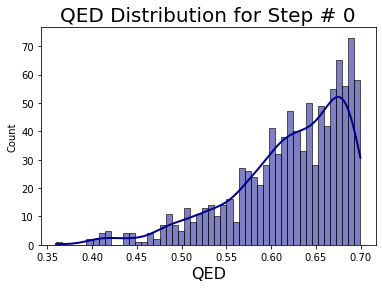

***********************************************************************************



In [7]:
# Test callback
%matplotlib inline
mol_callback = MolCallback(history_save_file='../molecule_pde_files/flow.pt',
                           vae=vae, v_model=lit_v_model, v_loss_functional='ce', decoding='greedy',
                           display_plots=True)
mol_callback.decode_and_calculate(embeddings_0, 0)

In [8]:
# Create the functionals
potential = PotentialFunctional(lit_v_model)
potential.to(device)
sinkhorn = SinkhornDivergenceFunctional(Y=embeddings_0, loss='sinkhorn', p=2, blur=.05, debias=False)
sinkhorn.to(device)
functional_sum = FunctionalSum([potential, sinkhorn], weights=[1, 1e4])

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.08e+01 77135.91  2.31e+04    5.40e+00     0.41     0.56   3.22e+00
 100   3.52e-01  2049.61  1.18e+02    1.93e-01     0.41     0.41   2.00e-02
 200   1.01e-01   697.17  2.11e+01    6.76e-02     0.41     0.41   2.11e-03
 300   6.17e-02   487.68  6.43e+00    4.81e-02     0.41     0.41   8.50e-04
 400   4.66e-02   407.20  1.67e+00    4.06e-02     0.41     0.41   6.23e-04
 500   3.73e-02   358.97 -3.63e-01    3.59e-02     0.41     0.41   8.46e-04

---> After JKO Step: 1, F(ρ)=3.5860e+02 <---


***********************************************************************************
		JKO STEP 1 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES percentage: 99.10% (991/1,000)
Percent unique (of valid): 100.00% (991/991)
Percent QED-

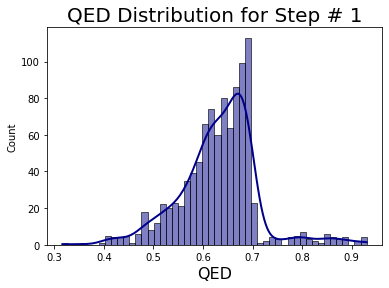

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.05e+01 56377.14  3.67e+03    5.27e+00     0.41     0.48   3.19e+00
 100   2.83e-01  2507.74  7.24e+02    1.78e-01     0.41     0.41   5.82e-02
 200   1.13e-01   959.89  3.32e+01    9.27e-02     0.41     0.41   2.09e-03
 300   7.33e-02   729.71  1.45e+01    7.15e-02     0.41     0.41   8.53e-04
 400   5.48e-02   617.55  6.48e+00    6.11e-02     0.41     0.41   5.76e-04
 500   4.31e-02   543.88  2.37e+00    5.42e-02     0.41     0.41   4.54e-04

---> After JKO Step: 2, F(ρ)=5.4325e+02 <---


***********************************************************************************
		JKO STEP 2 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

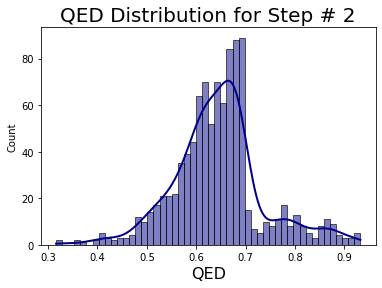

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.05e+01 65529.77  1.23e+04    5.33e+00     0.41     0.52   3.21e+00
 100   3.24e-01  2268.19  1.02e+02    2.17e-01     0.41     0.42   1.73e-02
 200   9.78e-02  1036.37  1.58e+01    1.02e-01     0.41     0.41   1.99e-03
 300   6.14e-02   821.27  3.02e+00    8.18e-02     0.41     0.41   8.58e-04
 400   4.80e-02   730.14 -8.08e-01    7.31e-02     0.41     0.41   5.82e-04
 500   3.99e-02   667.14 -2.27e+00    6.69e-02     0.41     0.41   5.24e-04

---> After JKO Step: 3, F(ρ)=6.6655e+02 <---


***********************************************************************************
		JKO STEP 3 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

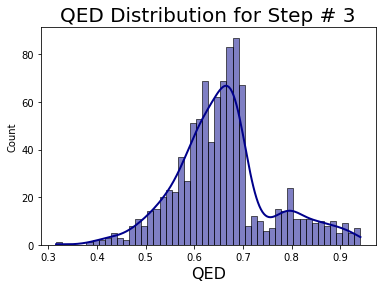

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.05e+01 65573.35  1.23e+04    5.32e+00     0.41     0.47   3.21e+00
 100   3.10e-01  2399.07  1.06e+02    2.29e-01     0.41     0.42   1.49e-02
 200   9.26e-02  1216.56  1.72e+01    1.20e-01     0.41     0.41   1.97e-03
 300   5.55e-02   994.67  3.87e+00    9.91e-02     0.41     0.41   8.51e-04
 400   4.18e-02   897.06 -5.12e-01    8.98e-02     0.41     0.41   5.67e-04
 500   3.43e-02   832.26 -2.21e+00    8.34e-02     0.41     0.41   5.50e-04

---> After JKO Step: 4, F(ρ)=8.3169e+02 <---


***********************************************************************************
		JKO STEP 4 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

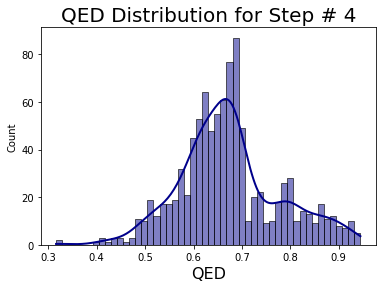

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.06e+01 58393.19  4.71e+03    5.37e+00     0.41     0.50   3.22e+00
 100   3.01e-01  2523.41  8.78e+01    2.44e-01     0.41     0.41   1.49e-02
 200   8.54e-02  1359.76  1.24e+01    1.35e-01     0.41     0.41   2.15e-03
 300   5.06e-02  1146.91  1.97e+00    1.14e-01     0.41     0.41   1.08e-03
 400   3.84e-02  1049.80 -1.27e+00    1.05e-01     0.41     0.41   7.22e-04
 500   3.12e-02   979.37 -2.51e+00    9.82e-02     0.41     0.41   1.65e-03

---> After JKO Step: 5, F(ρ)=9.7890e+02 <---


***********************************************************************************
		JKO STEP 5 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

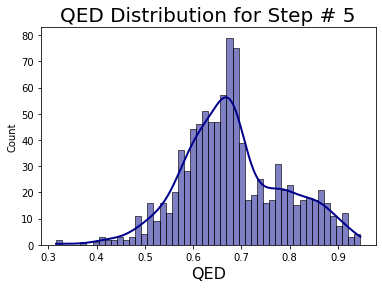

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.05e+01 54626.04  9.90e+02    5.36e+00     0.41     0.52   3.22e+00
 100   3.44e-01  2970.72  1.28e+02    2.84e-01     0.41     0.41   3.12e-02
 200   1.27e-01  1803.75  4.84e+01    1.76e-01     0.41     0.41   2.04e-03
 300   7.66e-02  1505.73  2.03e+01    1.49e-01     0.41     0.41   9.50e-04
 400   5.66e-02  1368.66  9.11e+00    1.36e-01     0.41     0.41   6.27e-04
 500   4.52e-02  1275.69  3.70e+00    1.27e-01     0.41     0.41   5.45e-04

---> After JKO Step: 6, F(ρ)=1.2749e+03 <---


***********************************************************************************
		JKO STEP 6 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

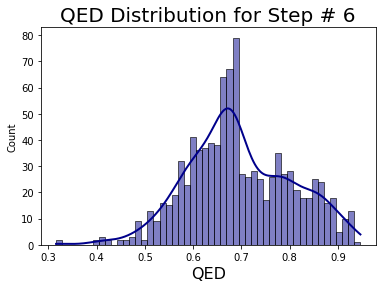

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.03e+01 60184.20  7.41e+03    5.28e+00     0.41     0.47   3.19e+00
 100   2.88e-01  2858.23  7.91e+01    2.78e-01     0.41     0.40   1.51e-02
 200   8.58e-02  1741.38  1.18e+01    1.73e-01     0.41     0.41   2.05e-03
 300   5.49e-02  1534.19  1.51e+00    1.53e-01     0.41     0.41   9.85e-04
 400   4.38e-02  1435.17 -1.52e+00    1.44e-01     0.41     0.41   6.17e-04
 500   3.74e-02  1360.61 -2.62e+00    1.36e-01     0.41     0.41   6.57e-04

---> After JKO Step: 7, F(ρ)=1.3601e+03 <---


***********************************************************************************
		JKO STEP 7 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

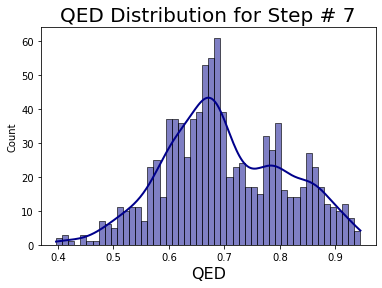

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.04e+01 87007.25  3.34e+04    5.36e+00     0.41     0.58   3.21e+00
 100   3.48e-01  3304.93  1.19e+02    3.19e-01     0.41     0.41   1.97e-02
 200   9.40e-02  1920.42  2.23e+01    1.90e-01     0.41     0.41   2.14e-03
 300   5.24e-02  1659.86  5.60e+00    1.65e-01     0.41     0.41   9.81e-04
 400   3.86e-02  1544.64  4.00e-01    1.54e-01     0.41     0.41   5.91e-04
 500   3.13e-02  1466.19 -1.62e+00    1.47e-01     0.41     0.41   6.19e-04

---> After JKO Step: 8, F(ρ)=1.4655e+03 <---


***********************************************************************************
		JKO STEP 8 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

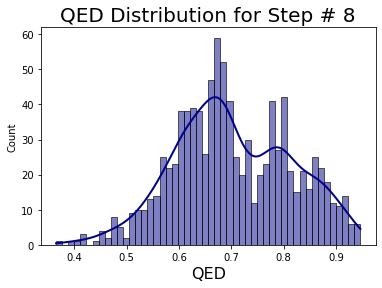

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.03e+01 73480.72  2.05e+04    5.30e+00     0.41     0.47   3.19e+00
 100   3.50e-01  3395.60  1.13e+02    3.28e-01     0.41     0.41   1.84e-02
 200   9.31e-02  2017.95  1.85e+01    2.00e-01     0.41     0.41   2.19e-03
 300   5.40e-02  1777.90  4.13e+00    1.77e-01     0.41     0.41   9.46e-04
 400   4.07e-02  1664.43 -2.48e-01    1.66e-01     0.41     0.41   6.64e-04
 500   3.37e-02  1582.18 -1.89e+00    1.58e-01     0.41     0.41   6.32e-04

---> After JKO Step: 9, F(ρ)=1.5814e+03 <---


***********************************************************************************
		JKO STEP 9 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES per

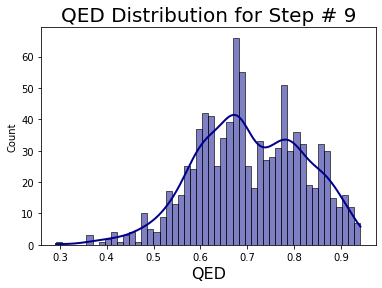

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.05e+01 86336.23  3.23e+04    5.40e+00     0.41     0.56   3.22e+00
 100   3.58e-01  3607.28  1.24e+02    3.48e-01     0.41     0.42   2.16e-02
 200   9.43e-02  2185.60  2.29e+01    2.16e-01     0.41     0.41   2.13e-03
 300   5.48e-02  1936.13  6.26e+00    1.93e-01     0.41     0.41   9.52e-04
 400   4.16e-02  1821.43  1.04e+00    1.82e-01     0.41     0.41   6.45e-04
 500   3.44e-02  1737.66 -1.18e+00    1.74e-01     0.41     0.41   7.15e-04

---> After JKO Step: 10, F(ρ)=1.7369e+03 <---


***********************************************************************************
		JKO STEP 10 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

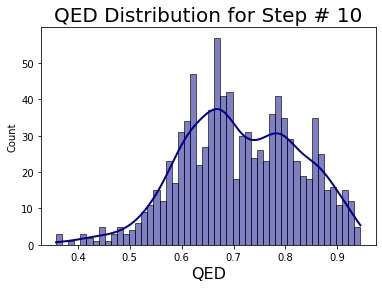

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.04e+01 59722.67  6.03e+03    5.37e+00     0.41     0.53   3.21e+00
 100   2.56e-01  3256.02  8.67e+01    3.17e-01     0.41     0.42   1.41e-02
 200   7.86e-02  2258.37  1.41e+01    2.24e-01     0.41     0.41   1.77e-03
 300   4.81e-02  2044.63  2.56e+00    2.04e-01     0.41     0.41   8.45e-04
 400   3.69e-02  1933.42 -1.17e+00    1.93e-01     0.41     0.41   7.03e-04
 500   3.10e-02  1851.80 -2.58e+00    1.85e-01     0.41     0.41   6.37e-04

---> After JKO Step: 11, F(ρ)=1.8512e+03 <---


***********************************************************************************
		JKO STEP 11 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

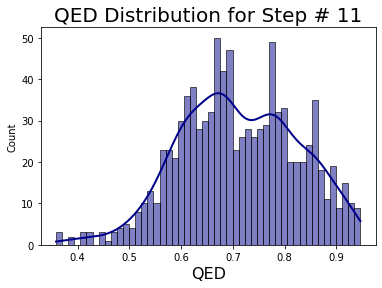

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.03e+01 100234.55  4.68e+04    5.34e+00     0.41     0.60   3.20e+00
 100   3.95e-01  4106.72  1.39e+02    3.97e-01     0.41     0.42   2.15e-02
 200   1.02e-01  2516.11  2.63e+01    2.49e-01     0.41     0.41   2.26e-03
 300   5.66e-02  2228.32  7.19e+00    2.22e-01     0.41     0.41   9.91e-04
 400   4.02e-02  2090.97  1.41e+00    2.09e-01     0.41     0.41   6.77e-04
 500   3.11e-02  1996.82 -8.81e-01    2.00e-01     0.41     0.41   6.68e-04

---> After JKO Step: 12, F(ρ)=1.9957e+03 <---


***********************************************************************************
		JKO STEP 12 End Summary:
Decoding embeddings to SMILES strings...(Took 0.29 seconds.)
Valid SMILES 

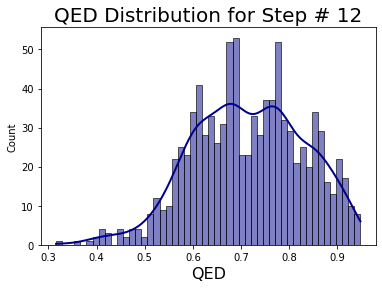

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.03e+01 65893.01  1.23e+04    5.36e+00     0.41     0.46   3.20e+00
 100   3.12e-01  3771.87  1.01e+02    3.67e-01     0.41     0.42   1.57e-02
 200   8.91e-02  2552.45  1.49e+01    2.54e-01     0.41     0.41   2.12e-03
 300   5.25e-02  2312.88  2.62e+00    2.31e-01     0.41     0.41   8.82e-04
 400   4.04e-02  2200.99 -1.06e+00    2.20e-01     0.41     0.41   6.35e-04
 500   3.39e-02  2119.06 -2.48e+00    2.12e-01     0.41     0.41   5.22e-04

---> After JKO Step: 13, F(ρ)=2.1184e+03 <---


***********************************************************************************
		JKO STEP 13 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

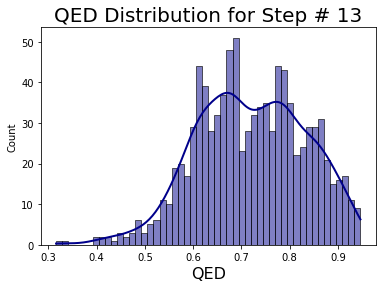

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.04e+01 82722.30  2.86e+04    5.41e+00     0.41     0.61   3.21e+00
 100   3.60e-01  4200.47  1.27e+02    4.07e-01     0.41     0.43   2.03e-02
 200   9.32e-02  2756.82  2.21e+01    2.73e-01     0.41     0.41   2.20e-03
 300   5.24e-02  2492.30  5.90e+00    2.49e-01     0.41     0.41   8.96e-04
 400   3.86e-02  2362.93  8.50e-01    2.36e-01     0.41     0.41   9.13e-04
 500   3.14e-02  2264.42 -1.24e+00    2.27e-01     0.41     0.41   6.02e-04

---> After JKO Step: 14, F(ρ)=2.2637e+03 <---


***********************************************************************************
		JKO STEP 14 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

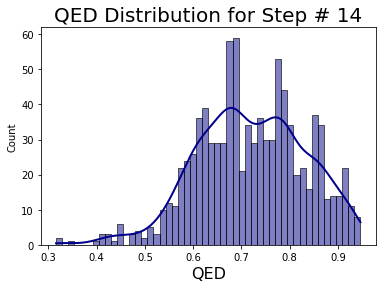

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.02e+01 66407.53  1.31e+04    5.34e+00     0.41     0.39   3.19e+00
 100   3.20e-01  4092.35  1.07e+02    3.99e-01     0.41     0.42   1.71e-02
 200   8.81e-02  2835.37  1.51e+01    2.82e-01     0.41     0.41   2.04e-03
 300   5.20e-02  2599.04  2.83e+00    2.60e-01     0.41     0.41   9.06e-04
 400   3.96e-02  2479.18 -8.89e-01    2.48e-01     0.41     0.41   6.16e-04
 500   3.30e-02  2386.93 -2.23e+00    2.39e-01     0.41     0.41   6.71e-04

---> After JKO Step: 15, F(ρ)=2.3864e+03 <---


***********************************************************************************
		JKO STEP 15 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

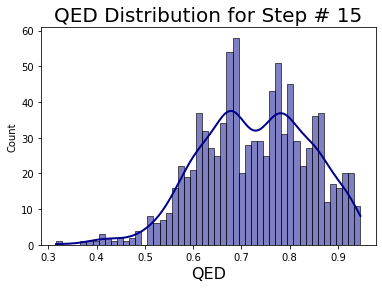

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 78608.55  2.55e+04    5.31e+00     0.41     0.52   3.17e+00
 100   3.56e-01  4424.55  1.22e+02    4.30e-01     0.41     0.42   1.90e-02
 200   9.32e-02  3012.05  2.12e+01    2.99e-01     0.41     0.41   2.24e-03
 300   5.23e-02  2747.83  5.62e+00    2.74e-01     0.41     0.41   1.12e-03
 400   3.81e-02  2616.72  6.08e-01    2.62e-01     0.41     0.41   7.28e-04
 500   3.04e-02  2520.57 -1.33e+00    2.52e-01     0.41     0.41   7.78e-04

---> After JKO Step: 16, F(ρ)=2.5197e+03 <---


***********************************************************************************
		JKO STEP 16 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

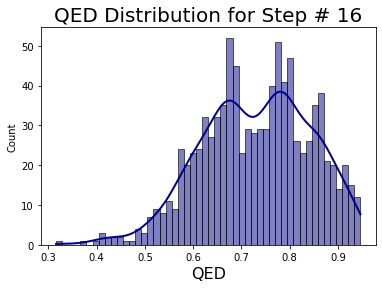

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 59915.96  6.82e+03    5.31e+00     0.41     0.59   3.17e+00
 100   2.82e-01  4103.84  9.53e+01    4.01e-01     0.41     0.41   1.48e-02
 200   7.92e-02  2995.24  1.44e+01    2.98e-01     0.41     0.41   1.99e-03
 300   4.63e-02  2766.54  2.77e+00    2.76e-01     0.41     0.41   1.05e-03
 400   3.55e-02  2651.69 -6.75e-01    2.65e-01     0.41     0.41   7.20e-04
 500   3.03e-02  2571.01 -2.00e+00    2.57e-01     0.41     0.41   1.01e-03

---> After JKO Step: 17, F(ρ)=2.5704e+03 <---


***********************************************************************************
		JKO STEP 17 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

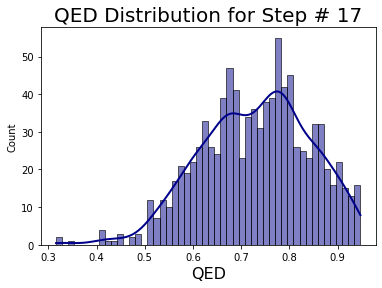

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 55989.94  2.79e+03    5.32e+00     0.41     0.53   3.17e+00
 100   2.54e-01  4063.27  7.76e+01    3.99e-01     0.41     0.41   1.43e-02
 200   7.54e-02  3093.27  1.14e+01    3.08e-01     0.41     0.41   1.76e-03
 300   4.47e-02  2876.67  1.24e+00    2.88e-01     0.41     0.41   9.44e-04
 400   3.34e-02  2752.72 -1.60e+00    2.75e-01     0.41     0.41   1.18e-03
 500   2.78e-02  2657.66 -2.70e+00    2.66e-01     0.41     0.41   7.81e-04

---> After JKO Step: 18, F(ρ)=2.6570e+03 <---


***********************************************************************************
		JKO STEP 18 End Summary:
Decoding embeddings to SMILES strings...(Took 0.28 seconds.)
Valid SMILES p

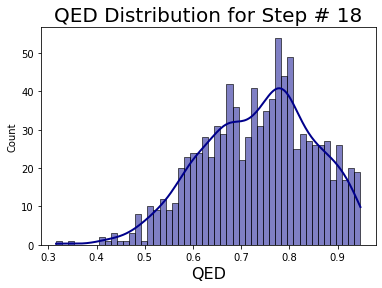

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 63796.27  1.06e+04    5.32e+00     0.41     0.52   3.17e+00
 100   2.92e-01  4386.82  9.84e+01    4.29e-01     0.41     0.42   1.55e-02
 200   8.41e-02  3243.92  1.54e+01    3.23e-01     0.41     0.41   2.05e-03
 300   4.88e-02  3003.59  2.77e+00    3.00e-01     0.41     0.41   9.11e-04
 400   3.70e-02  2883.76 -1.01e+00    2.88e-01     0.41     0.41   1.02e-03
 500   3.10e-02  2791.60 -2.42e+00    2.79e-01     0.41     0.41   8.26e-04

---> After JKO Step: 19, F(ρ)=2.7908e+03 <---


***********************************************************************************
		JKO STEP 19 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

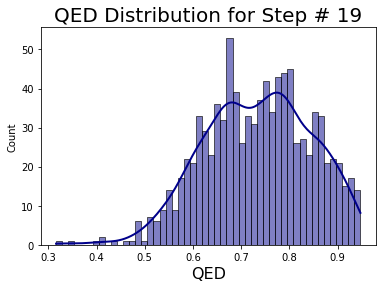

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.02e+01 63756.56  9.94e+03    5.38e+00     0.41     0.53   3.18e+00
 100   2.85e-01  4446.94  9.33e+01    4.35e-01     0.41     0.41   1.65e-02
 200   8.00e-02  3310.71  1.44e+01    3.30e-01     0.41     0.41   1.84e-03
 300   4.76e-02  3081.77  2.53e+00    3.08e-01     0.41     0.41   8.74e-04
 400   3.56e-02  2954.88 -1.06e+00    2.96e-01     0.41     0.41   6.85e-04
 500   2.93e-02  2863.29 -2.44e+00    2.87e-01     0.41     0.41   6.35e-04

---> After JKO Step: 20, F(ρ)=2.8624e+03 <---


***********************************************************************************
		JKO STEP 20 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

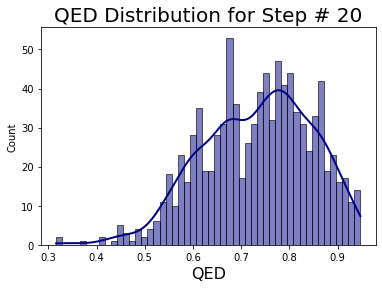

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.00e+01 53907.68  7.82e+02    5.31e+00     0.41     0.55   3.16e+00
 100   2.53e-01  4352.17  6.71e+01    4.29e-01     0.41     0.40   1.48e-02
 200   7.43e-02  3377.91  9.82e+00    3.37e-01     0.41     0.41   1.89e-03
 300   4.38e-02  3162.65  1.12e+00    3.16e-01     0.41     0.41   8.51e-04
 400   3.33e-02  3044.31 -1.58e+00    3.05e-01     0.41     0.41   2.22e-03
 500   2.79e-02  2954.79 -2.68e+00    2.96e-01     0.41     0.41   1.43e-03

---> After JKO Step: 21, F(ρ)=2.9540e+03 <---


***********************************************************************************
		JKO STEP 21 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

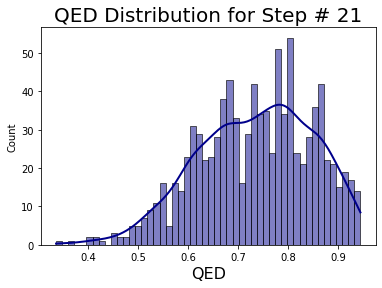

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.02e+01 66919.83  1.31e+04    5.38e+00     0.41     0.49   3.18e+00
 100   3.18e-01  4843.99  1.00e+02    4.74e-01     0.41     0.42   1.71e-02
 200   8.59e-02  3572.36  1.51e+01    3.56e-01     0.41     0.40   2.14e-03
 300   4.85e-02  3311.18  2.83e+00    3.31e-01     0.41     0.41   9.15e-04
 400   3.68e-02  3180.70 -7.84e-01    3.18e-01     0.41     0.41   7.59e-04
 500   3.12e-02  3081.89 -2.19e+00    3.08e-01     0.41     0.41   8.04e-04

---> After JKO Step: 22, F(ρ)=3.0810e+03 <---


***********************************************************************************
		JKO STEP 22 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

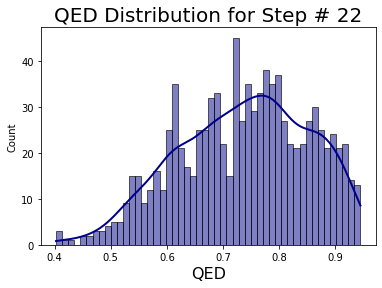

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 67967.34  1.44e+04    5.35e+00     0.41     0.53   3.17e+00
 100   3.06e-01  4891.66  9.91e+01    4.79e-01     0.41     0.41   1.64e-02
 200   8.74e-02  3696.21  1.69e+01    3.68e-01     0.41     0.41   2.05e-03
 300   5.12e-02  3449.09  3.82e+00    3.45e-01     0.41     0.41   9.89e-04
 400   3.84e-02  3315.38 -4.08e-01    3.32e-01     0.41     0.41   7.26e-04
 500   3.16e-02  3212.91 -2.09e+00    3.21e-01     0.41     0.41   6.35e-04

---> After JKO Step: 23, F(ρ)=3.2120e+03 <---


***********************************************************************************
		JKO STEP 23 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

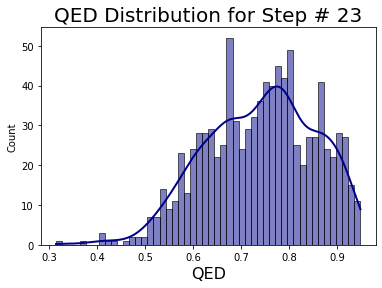

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 57443.68  3.99e+03    5.35e+00     0.41     0.50   3.16e+00
 100   2.68e-01  4811.81  7.91e+01    4.73e-01     0.41     0.41   1.34e-02
 200   7.93e-02  3764.38  1.16e+01    3.75e-01     0.41     0.41   2.01e-03
 300   4.68e-02  3527.83  1.29e+00    3.53e-01     0.41     0.41   1.30e-03
 400   3.63e-02  3402.33 -1.74e+00    3.40e-01     0.41     0.41   1.03e-03
 500   3.13e-02  3308.03 -2.76e+00    3.31e-01     0.41     0.41   1.10e-03

---> After JKO Step: 24, F(ρ)=3.3073e+03 <---


***********************************************************************************
		JKO STEP 24 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

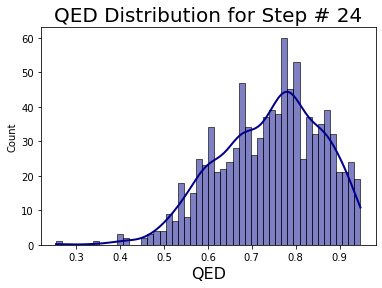

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.95e+00 84877.24  3.18e+04    5.30e+00     0.41     0.60   3.15e+00
 100   3.55e-01  5396.14  1.29e+02    5.27e-01     0.41     0.42   1.82e-02
 200   1.00e-01  3998.13  2.63e+01    3.97e-01     0.41     0.41   2.25e-03
 300   5.53e-02  3697.05  7.91e+00    3.69e-01     0.41     0.41   9.98e-04
 400   4.09e-02  3550.15  1.86e+00    3.55e-01     0.41     0.41   7.24e-04
 500   3.36e-02  3440.04 -5.94e-01    3.44e-01     0.41     0.41   6.37e-04

---> After JKO Step: 25, F(ρ)=3.4388e+03 <---


***********************************************************************************
		JKO STEP 25 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

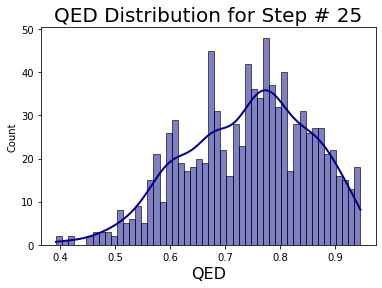

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.95e+00 87641.20  3.45e+04    5.32e+00     0.41     0.60   3.15e+00
 100   3.63e-01  5508.00  1.32e+02    5.38e-01     0.41     0.42   2.17e-02
 200   9.37e-02  4036.39  2.47e+01    4.01e-01     0.41     0.41   2.21e-03
 300   5.27e-02  3748.96  7.02e+00    3.74e-01     0.41     0.41   1.08e-03
 400   3.93e-02  3602.18  1.69e+00    3.60e-01     0.41     0.41   8.43e-04
 500   3.25e-02  3491.07 -5.21e-01    3.49e-01     0.41     0.41   9.62e-04

---> After JKO Step: 26, F(ρ)=3.4900e+03 <---


***********************************************************************************
		JKO STEP 26 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

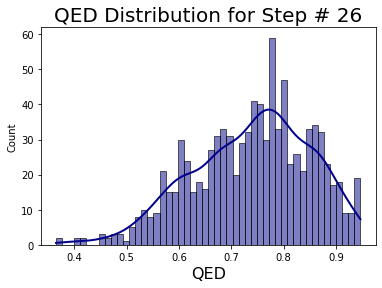

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.97e+00 63882.71  1.06e+04    5.33e+00     0.41     0.43   3.15e+00
 100   2.99e-01  5226.97  9.58e+01    5.13e-01     0.41     0.41   1.63e-02
 200   8.67e-02  4059.83  1.41e+01    4.05e-01     0.41     0.41   2.04e-03
 300   5.10e-02  3808.72  2.38e+00    3.81e-01     0.41     0.41   9.65e-04
 400   3.83e-02  3674.17 -1.03e+00    3.68e-01     0.41     0.41   8.17e-04
 500   3.19e-02  3572.26 -2.27e+00    3.57e-01     0.41     0.41   6.68e-04

---> After JKO Step: 27, F(ρ)=3.5708e+03 <---


***********************************************************************************
		JKO STEP 27 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

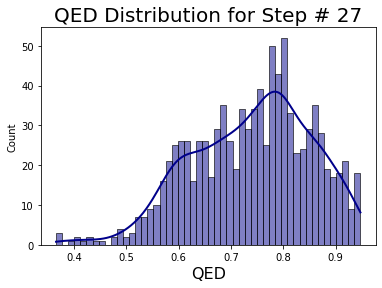

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.91e+00 68624.03  1.55e+04    5.31e+00     0.41     0.51   3.14e+00
 100   3.25e-01  5449.67  1.09e+02    5.34e-01     0.41     0.41   1.57e-02
 200   8.97e-02  4159.57  1.72e+01    4.14e-01     0.41     0.41   2.24e-03
 300   5.12e-02  3888.22  3.89e+00    3.88e-01     0.41     0.41   1.20e-03
 400   3.85e-02  3748.76 -8.78e-02    3.75e-01     0.41     0.41   1.22e-03
 500   3.21e-02  3642.44 -1.67e+00    3.64e-01     0.41     0.41   7.98e-04

---> After JKO Step: 28, F(ρ)=3.6415e+03 <---


***********************************************************************************
		JKO STEP 28 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

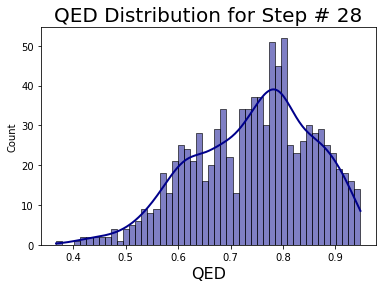

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 66382.36  1.22e+04    5.41e+00     0.41     0.59   3.17e+00
 100   2.87e-01  5352.82  9.84e+01    5.25e-01     0.41     0.41   1.50e-02
 200   8.25e-02  4209.65  1.44e+01    4.20e-01     0.41     0.41   1.90e-03
 300   4.91e-02  3958.78  2.93e+00    3.96e-01     0.41     0.41   1.01e-03
 400   3.67e-02  3816.71 -7.01e-01    3.82e-01     0.41     0.41   7.50e-04
 500   3.06e-02  3710.36 -2.13e+00    3.71e-01     0.41     0.41   9.27e-04

---> After JKO Step: 29, F(ρ)=3.7091e+03 <---


***********************************************************************************
		JKO STEP 29 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

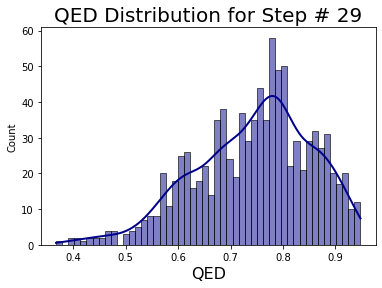

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.93e+00 90114.52  3.67e+04    5.34e+00     0.41     0.61   3.14e+00
 100   3.85e-01  5896.46  1.34e+02    5.76e-01     0.41     0.42   2.00e-02
 200   1.06e-01  4394.35  3.02e+01    4.36e-01     0.41     0.41   2.46e-03
 300   5.89e-02  4080.28  9.31e+00    4.07e-01     0.41     0.41   1.03e-03
 400   4.32e-02  3924.52  2.80e+00    3.92e-01     0.41     0.41   1.06e-03
 500   3.58e-02  3810.10  9.17e-02    3.81e-01     0.41     0.41   6.95e-04

---> After JKO Step: 30, F(ρ)=3.8092e+03 <---


***********************************************************************************
		JKO STEP 30 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

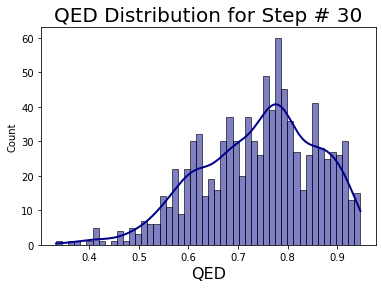

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.88e+00 86122.94  3.30e+04    5.32e+00     0.41     0.44   3.14e+00
 100   3.45e-01  5785.62  1.17e+02    5.67e-01     0.41     0.42   2.21e-02
 200   9.78e-02  4428.09  2.10e+01    4.41e-01     0.41     0.40   2.18e-03
 300   5.78e-02  4143.35  5.47e+00    4.14e-01     0.41     0.40   1.06e-03
 400   4.46e-02  3995.50  7.79e-01    3.99e-01     0.41     0.41   8.41e-04
 500   3.84e-02  3884.08 -1.13e+00    3.89e-01     0.41     0.41   7.43e-04

---> After JKO Step: 31, F(ρ)=3.8833e+03 <---


***********************************************************************************
		JKO STEP 31 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

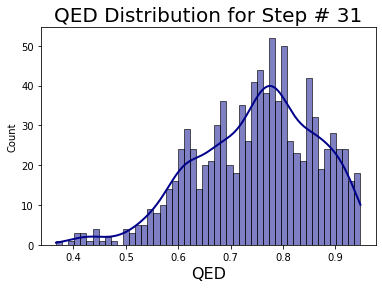

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.95e+00 63633.02  1.00e+04    5.36e+00     0.41     0.59   3.15e+00
 100   3.08e-01  5677.48  9.44e+01    5.58e-01     0.41     0.41   1.71e-02
 200   8.69e-02  4463.96  1.36e+01    4.45e-01     0.41     0.40   2.16e-03
 300   4.97e-02  4188.25  2.34e+00    4.19e-01     0.41     0.40   1.08e-03
 400   3.73e-02  4035.30 -1.14e+00    4.04e-01     0.41     0.41   1.01e-03
 500   3.13e-02  3918.66 -2.47e+00    3.92e-01     0.41     0.41   1.08e-03

---> After JKO Step: 32, F(ρ)=3.9175e+03 <---


***********************************************************************************
		JKO STEP 32 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

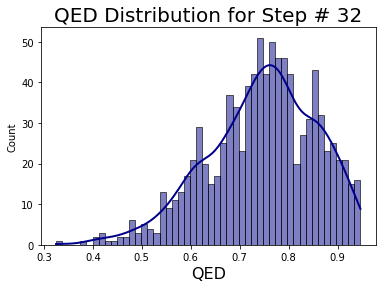

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.90e+00 57151.93  3.77e+03    5.34e+00     0.41     0.49   3.14e+00
 100   2.56e-01  5429.09  7.74e+01    5.35e-01     0.41     0.41   1.34e-02
 200   7.39e-02  4412.13  1.06e+01    4.40e-01     0.41     0.40   1.94e-03
 300   4.39e-02  4183.77  1.12e+00    4.18e-01     0.41     0.40   1.09e-03
 400   3.42e-02  4057.34 -1.63e+00    4.06e-01     0.41     0.40   8.11e-04
 500   2.97e-02  3963.45 -2.66e+00    3.97e-01     0.41     0.40   1.43e-03

---> After JKO Step: 33, F(ρ)=3.9626e+03 <---


***********************************************************************************
		JKO STEP 33 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

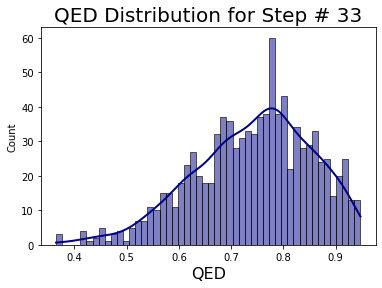

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.96e+00 81495.72  2.79e+04    5.36e+00     0.40     0.53   3.15e+00
 100   3.40e-01  5955.12  1.27e+02    5.83e-01     0.40     0.41   1.95e-02
 200   1.01e-01  4651.88  2.46e+01    4.63e-01     0.40     0.40   2.19e-03
 300   5.64e-02  4350.68  7.07e+00    4.34e-01     0.40     0.40   1.31e-03
 400   4.11e-02  4192.35  1.53e+00    4.19e-01     0.40     0.40   9.19e-04
 500   3.39e-02  4073.43 -8.45e-01    4.07e-01     0.40     0.40   8.28e-04

---> After JKO Step: 34, F(ρ)=4.0720e+03 <---


***********************************************************************************
		JKO STEP 34 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

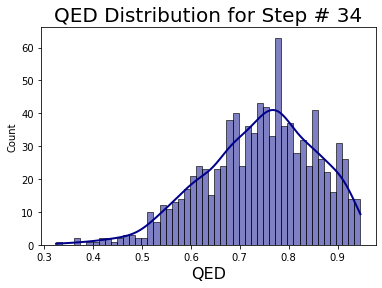

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.84e+00 62253.65  9.18e+03    5.31e+00     0.40     0.53   3.13e+00
 100   2.98e-01  5771.89  9.32e+01    5.68e-01     0.40     0.41   1.41e-02
 200   8.07e-02  4573.55  1.39e+01    4.56e-01     0.40     0.40   2.06e-03
 300   4.65e-02  4316.66  2.63e+00    4.31e-01     0.40     0.40   1.17e-03
 400   3.57e-02  4180.75 -7.14e-01    4.18e-01     0.40     0.40   8.88e-04
 500   3.12e-02  4077.88 -1.95e+00    4.08e-01     0.40     0.40   8.79e-04

---> After JKO Step: 35, F(ρ)=4.0772e+03 <---


***********************************************************************************
		JKO STEP 35 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

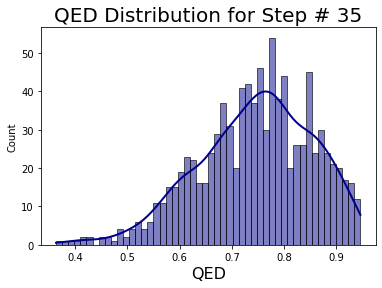

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.79e+00 67050.01  1.42e+04    5.28e+00     0.40     0.51   3.12e+00
 100   3.32e-01  5992.86  1.01e+02    5.89e-01     0.40     0.42   1.83e-02
 200   8.73e-02  4673.37  1.54e+01    4.66e-01     0.40     0.40   2.25e-03
 300   4.80e-02  4393.58  2.84e+00    4.39e-01     0.40     0.40   1.10e-03
 400   3.61e-02  4247.08 -8.85e-01    4.25e-01     0.40     0.40   7.97e-04
 500   3.08e-02  4139.17 -2.32e+00    4.14e-01     0.40     0.40   8.58e-04

---> After JKO Step: 36, F(ρ)=4.1378e+03 <---


***********************************************************************************
		JKO STEP 36 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

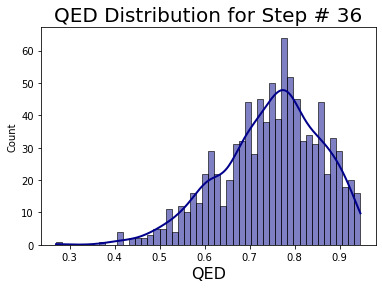

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.97e+00 71403.69  1.76e+04    5.38e+00     0.40     0.56   3.15e+00
 100   3.36e-01  6074.59  1.15e+02    5.96e-01     0.40     0.40   1.82e-02
 200   8.73e-02  4707.44  1.69e+01    4.69e-01     0.40     0.40   2.33e-03
 300   5.04e-02  4436.11  3.84e+00    4.43e-01     0.40     0.40   9.10e-04
 400   3.89e-02  4300.28 -6.72e-02    4.30e-01     0.40     0.40   8.00e-04
 500   3.29e-02  4195.31 -1.66e+00    4.20e-01     0.40     0.40   1.03e-03

---> After JKO Step: 37, F(ρ)=4.1938e+03 <---


***********************************************************************************
		JKO STEP 37 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

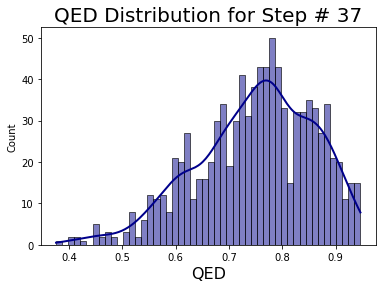

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.93e+00 58622.04  5.06e+03    5.36e+00     0.40     0.51   3.14e+00
 100   2.54e-01  5721.07  7.90e+01    5.64e-01     0.40     0.40   1.38e-02
 200   7.92e-02  4736.75  1.23e+01    4.72e-01     0.40     0.40   1.83e-03
 300   4.75e-02  4499.87  1.74e+00    4.50e-01     0.40     0.40   1.09e-03
 400   3.66e-02  4363.35 -1.53e+00    4.36e-01     0.40     0.40   8.50e-04
 500   3.15e-02  4255.92 -2.78e+00    4.26e-01     0.40     0.40   7.79e-04

---> After JKO Step: 38, F(ρ)=4.2549e+03 <---


***********************************************************************************
		JKO STEP 38 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

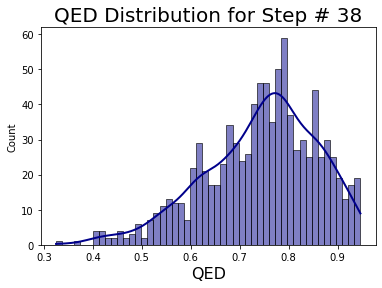

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.84e+00 69434.41  1.63e+04    5.31e+00     0.40     0.47   3.13e+00
 100   3.06e-01  6091.70  1.06e+02    5.99e-01     0.40     0.41   1.68e-02
 200   8.89e-02  4896.62  1.89e+01    4.88e-01     0.40     0.40   2.30e-03
 300   5.08e-02  4620.06  4.71e+00    4.62e-01     0.40     0.40   1.03e-03
 400   3.81e-02  4469.26  2.53e-01    4.47e-01     0.40     0.40   7.25e-04
 500   3.23e-02  4354.39 -1.59e+00    4.36e-01     0.40     0.40   8.81e-04

---> After JKO Step: 39, F(ρ)=4.3534e+03 <---


***********************************************************************************
		JKO STEP 39 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

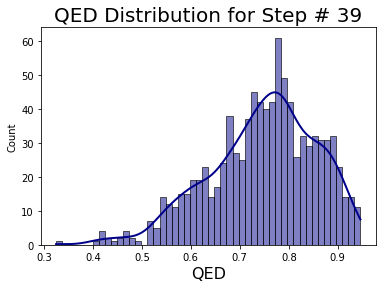

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.93e+00 88513.27  3.49e+04    5.36e+00     0.40     0.51   3.14e+00
 100   3.78e-01  6540.79  1.26e+02    6.41e-01     0.40     0.41   1.96e-02
 200   1.05e-01  5065.22  2.90e+01    5.04e-01     0.40     0.40   2.33e-03
 300   5.69e-02  4736.05  9.02e+00    4.73e-01     0.40     0.40   1.20e-03
 400   4.09e-02  4570.72  2.45e+00    4.57e-01     0.40     0.40   8.44e-04
 500   3.35e-02  4451.73 -3.52e-01    4.45e-01     0.40     0.40   7.07e-04

---> After JKO Step: 40, F(ρ)=4.4509e+03 <---


***********************************************************************************
		JKO STEP 40 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

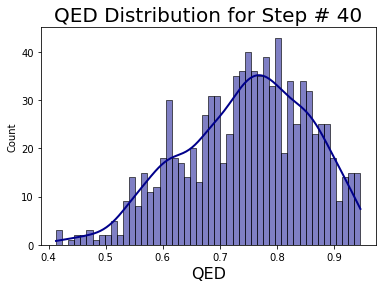

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.88e+00 69173.68  1.58e+04    5.34e+00     0.40     0.58   3.13e+00
 100   3.00e-01  6198.32  1.01e+02    6.10e-01     0.40     0.40   1.70e-02
 200   8.48e-02  5006.68  1.52e+01    4.99e-01     0.40     0.40   2.04e-03
 300   4.97e-02  4740.64  2.96e+00    4.74e-01     0.40     0.40   9.37e-04
 400   3.81e-02  4596.13 -4.83e-01    4.60e-01     0.40     0.40   6.58e-04
 500   3.26e-02  4489.90 -1.79e+00    4.49e-01     0.40     0.40   7.15e-04

---> After JKO Step: 41, F(ρ)=4.4890e+03 <---


***********************************************************************************
		JKO STEP 41 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

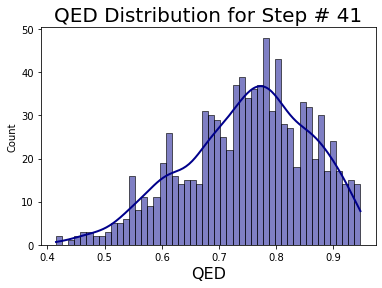

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.79e+00 77427.55  2.44e+04    5.31e+00     0.40     0.54   3.12e+00
 100   3.47e-01  6472.29  1.18e+02    6.35e-01     0.40     0.41   1.80e-02
 200   9.96e-02  5113.23  2.28e+01    5.09e-01     0.40     0.40   2.36e-03
 300   5.60e-02  4806.91  6.05e+00    4.80e-01     0.40     0.40   1.14e-03
 400   4.23e-02  4648.01  9.36e-01    4.65e-01     0.40     0.40   8.48e-04
 500   3.63e-02  4533.73 -1.11e+00    4.53e-01     0.40     0.40   7.11e-04

---> After JKO Step: 42, F(ρ)=4.5333e+03 <---


***********************************************************************************
		JKO STEP 42 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

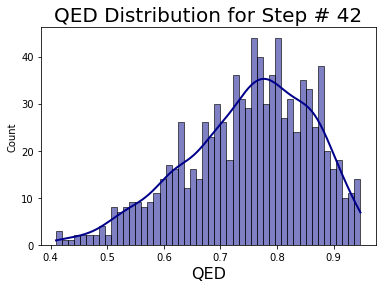

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.86e+00 92823.98  3.94e+04    5.34e+00     0.40     0.57   3.13e+00
 100   3.63e-01  6613.09  1.27e+02    6.49e-01     0.40     0.41   2.21e-02
 200   1.04e-01  5221.28  2.50e+01    5.20e-01     0.40     0.39   2.27e-03
 300   5.92e-02  4908.44  7.31e+00    4.90e-01     0.40     0.39   1.17e-03
 400   4.40e-02  4745.77  1.73e+00    4.74e-01     0.40     0.40   7.66e-04
 500   3.69e-02  4627.36 -6.81e-01    4.63e-01     0.40     0.40   8.15e-04

---> After JKO Step: 43, F(ρ)=4.6260e+03 <---


***********************************************************************************
		JKO STEP 43 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

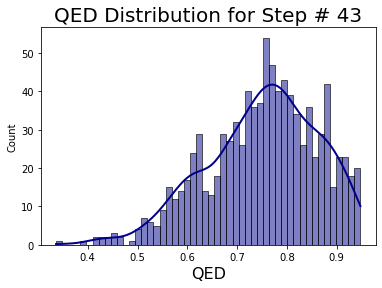

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.95e+00 69226.95  1.53e+04    5.39e+00     0.40     0.58   3.15e+00
 100   3.21e-01  6510.46  1.14e+02    6.40e-01     0.40     0.40   1.52e-02
 200   9.59e-02  5243.23  1.88e+01    5.22e-01     0.40     0.39   2.13e-03
 300   5.59e-02  4954.70  4.17e+00    4.95e-01     0.40     0.39   1.05e-03
 400   4.23e-02  4797.67 -7.55e-02    4.80e-01     0.40     0.39   6.96e-04
 500   3.59e-02  4681.08 -1.66e+00    4.68e-01     0.40     0.39   7.73e-04

---> After JKO Step: 44, F(ρ)=4.6801e+03 <---


***********************************************************************************
		JKO STEP 44 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

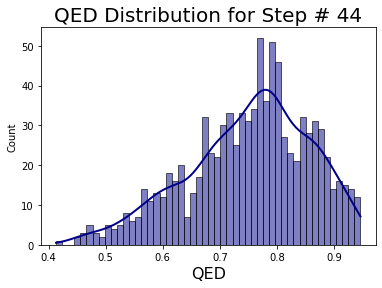

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.81e+00 57438.34  4.19e+03    5.32e+00     0.39     0.56   3.12e+00
 100   2.63e-01  6255.89  7.61e+01    6.18e-01     0.39     0.40   1.38e-02
 200   7.62e-02  5198.61  1.12e+01    5.19e-01     0.39     0.39   1.89e-03
 300   4.53e-02  4950.34  1.46e+00    4.95e-01     0.39     0.39   1.14e-03
 400   3.53e-02  4807.58 -1.47e+00    4.81e-01     0.39     0.39   1.14e-03
 500   3.10e-02  4697.62 -2.58e+00    4.70e-01     0.39     0.39   7.67e-04

---> After JKO Step: 45, F(ρ)=4.6960e+03 <---


***********************************************************************************
		JKO STEP 45 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

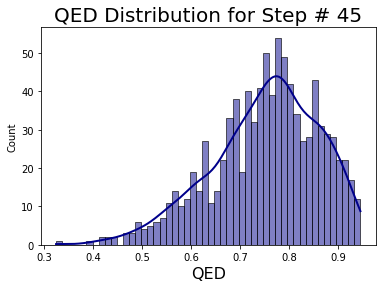

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.72e+00 53252.00  4.83e+02    5.28e+00     0.39     0.47   3.11e+00
 100   2.15e-01  6067.18  5.54e+01    6.01e-01     0.39     0.40   1.31e-02
 200   7.11e-02  5237.45  6.63e+00    5.23e-01     0.39     0.39   1.85e-03
 300   4.26e-02  4998.68 -2.00e-01    5.00e-01     0.39     0.39   3.29e-03
 400   3.27e-02  4853.59 -2.39e+00    4.86e-01     0.39     0.39   2.10e-03
 500   2.85e-02  4734.89 -2.99e+00    4.74e-01     0.39     0.39   6.30e-03

---> After JKO Step: 46, F(ρ)=4.7337e+03 <---


***********************************************************************************
		JKO STEP 46 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

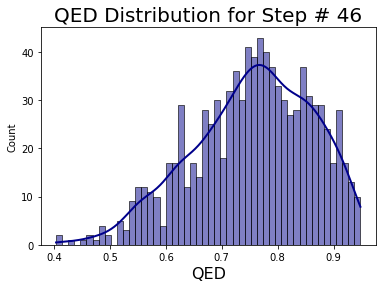

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.82e+00 76770.77  2.35e+04    5.33e+00     0.39     0.51   3.12e+00
 100   3.54e-01  6811.70  1.24e+02    6.69e-01     0.39     0.40   1.89e-02
 200   9.96e-02  5414.65  2.15e+01    5.39e-01     0.39     0.39   2.21e-03
 300   5.48e-02  5100.57  6.01e+00    5.09e-01     0.39     0.39   1.07e-03
 400   3.96e-02  4929.73  9.91e-01    4.93e-01     0.39     0.39   7.65e-04
 500   3.27e-02  4803.76 -1.17e+00    4.80e-01     0.39     0.39   8.14e-04

---> After JKO Step: 47, F(ρ)=4.8029e+03 <---


***********************************************************************************
		JKO STEP 47 End Summary:
Decoding embeddings to SMILES strings...(Took 0.16 seconds.)
Valid SMILES p

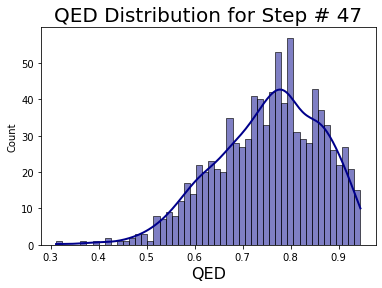

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.79e+00 63594.12  1.05e+04    5.31e+00     0.39     0.39   3.12e+00
 100   2.77e-01  6476.42  8.95e+01    6.39e-01     0.39     0.41   1.61e-02
 200   8.07e-02  5362.83  1.30e+01    5.35e-01     0.39     0.39   1.89e-03
 300   4.91e-02  5109.13  2.34e+00    5.11e-01     0.39     0.39   9.35e-04
 400   3.84e-02  4958.82 -9.76e-01    4.96e-01     0.39     0.39   8.15e-04
 500   3.35e-02  4835.06 -2.30e+00    4.84e-01     0.39     0.39   1.04e-03

---> After JKO Step: 48, F(ρ)=4.8346e+03 <---


***********************************************************************************
		JKO STEP 48 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

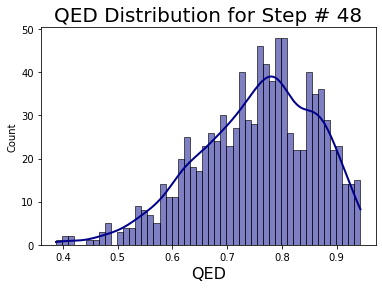

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.73e+00 96361.70  4.35e+04    5.28e+00     0.39     0.51   3.11e+00
 100   3.72e-01  6974.73  1.29e+02    6.85e-01     0.39     0.41   2.03e-02
 200   9.80e-02  5487.42  2.58e+01    5.46e-01     0.39     0.39   2.33e-03
 300   5.37e-02  5165.94  7.73e+00    5.16e-01     0.39     0.39   1.58e-03
 400   3.94e-02  4994.46  2.11e+00    4.99e-01     0.39     0.39   8.29e-04
 500   3.30e-02  4866.81  2.84e-02    4.87e-01     0.39     0.39   9.94e-04

---> After JKO Step: 49, F(ρ)=4.8654e+03 <---


***********************************************************************************
		JKO STEP 49 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

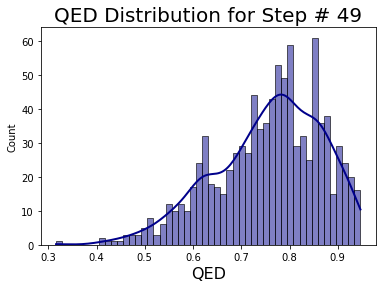

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.94e+00 80598.30  2.67e+04    5.39e+00     0.39     0.62   3.14e+00
 100   3.51e-01  6850.51  1.13e+02    6.74e-01     0.39     0.41   1.87e-02
 200   1.01e-01  5505.87  2.04e+01    5.49e-01     0.39     0.39   2.19e-03
 300   5.64e-02  5196.32  5.24e+00    5.19e-01     0.39     0.39   1.04e-03
 400   4.21e-02  5033.32  5.84e-01    5.03e-01     0.39     0.39   8.96e-04
 500   3.57e-02  4915.75 -1.37e+00    4.92e-01     0.39     0.39   7.29e-04

---> After JKO Step: 50, F(ρ)=4.9149e+03 <---


***********************************************************************************
		JKO STEP 50 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

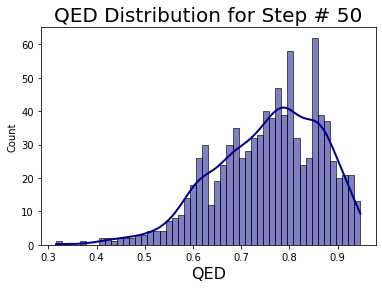

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.83e+00 58711.52  5.33e+03    5.34e+00     0.39     0.53   3.13e+00
 100   2.97e-01  6647.95  6.70e+01    6.58e-01     0.39     0.42   4.64e-02
 200   1.02e-01  5594.83  2.53e+01    5.57e-01     0.39     0.39   2.28e-03
 300   6.03e-02  5302.26  9.00e+00    5.29e-01     0.39     0.39   1.16e-03
 400   4.41e-02  5135.48  3.08e+00    5.13e-01     0.39     0.39   9.36e-04
 500   3.59e-02  5002.90  3.21e-01    5.00e-01     0.39     0.39   8.12e-04

---> After JKO Step: 51, F(ρ)=5.0022e+03 <---


***********************************************************************************
		JKO STEP 51 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

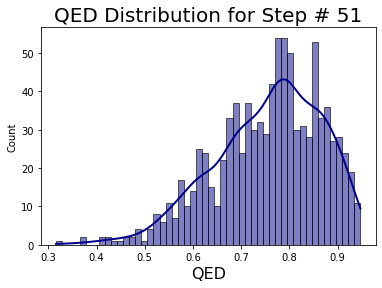

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.90e+00 75097.97  2.14e+04    5.37e+00     0.39     0.49   3.14e+00
 100   3.42e-01  6988.57  1.13e+02    6.88e-01     0.39     0.40   1.87e-02
 200   9.71e-02  5642.50  2.03e+01    5.62e-01     0.39     0.39   2.24e-03
 300   5.52e-02  5333.18  4.96e+00    5.33e-01     0.39     0.39   1.06e-03
 400   4.20e-02  5170.05  1.86e-01    5.17e-01     0.39     0.39   8.60e-04
 500   3.58e-02  5044.65 -1.68e+00    5.05e-01     0.39     0.39   7.26e-04

---> After JKO Step: 52, F(ρ)=5.0440e+03 <---


***********************************************************************************
		JKO STEP 52 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

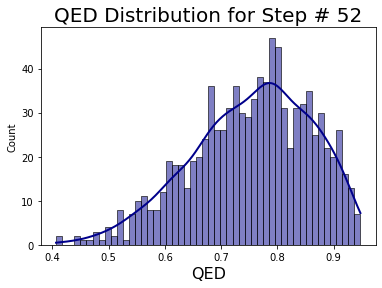

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.86e+00 78850.09  2.53e+04    5.35e+00     0.39     0.53   3.13e+00
 100   3.63e-01  7150.63  1.18e+02    7.03e-01     0.39     0.40   1.87e-02
 200   1.02e-01  5722.68  2.30e+01    5.70e-01     0.39     0.39   2.31e-03
 300   5.71e-02  5399.92  6.32e+00    5.39e-01     0.39     0.39   1.16e-03
 400   4.30e-02  5233.31  1.25e+00    5.23e-01     0.39     0.39   8.96e-04
 500   3.65e-02  5097.43 -9.25e-01    5.10e-01     0.39     0.39   7.51e-04

---> After JKO Step: 53, F(ρ)=5.0966e+03 <---


***********************************************************************************
		JKO STEP 53 End Summary:
Decoding embeddings to SMILES strings...(Took 0.29 seconds.)
Valid SMILES p

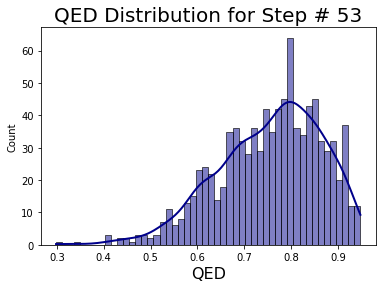

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.94e+00 68797.45  1.49e+04    5.39e+00     0.39     0.52   3.14e+00
 100   3.17e-01  6918.39  1.04e+02    6.81e-01     0.39     0.40   1.78e-02
 200   8.89e-02  5681.57  1.50e+01    5.67e-01     0.39     0.39   2.10e-03
 300   5.12e-02  5396.82  2.87e+00    5.39e-01     0.39     0.38   9.57e-04
 400   3.90e-02  5228.90 -6.15e-01    5.23e-01     0.39     0.39   8.14e-04
 500   3.36e-02  5099.85 -1.97e+00    5.10e-01     0.39     0.39   7.37e-04

---> After JKO Step: 54, F(ρ)=5.0985e+03 <---


***********************************************************************************
		JKO STEP 54 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

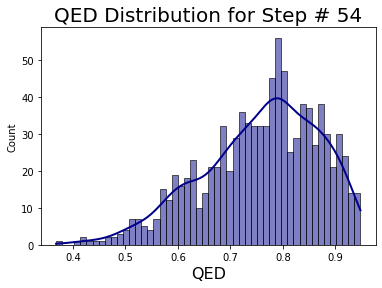

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.87e+00 54171.38  5.74e+02    5.36e+00     0.39     0.56   3.13e+00
 100   2.35e-01  6585.16  7.37e+01    6.51e-01     0.39     0.40   1.33e-02
 200   7.61e-02  5648.22  1.27e+01    5.64e-01     0.39     0.39   1.86e-03
 300   4.76e-02  5402.68  2.08e+00    5.40e-01     0.39     0.39   1.05e-03
 400   3.75e-02  5250.51 -1.24e+00    5.25e-01     0.39     0.38   1.14e-03
 500   3.32e-02  5134.19 -2.41e+00    5.14e-01     0.39     0.38   1.11e-03

---> After JKO Step: 55, F(ρ)=5.1334e+03 <---


***********************************************************************************
		JKO STEP 55 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

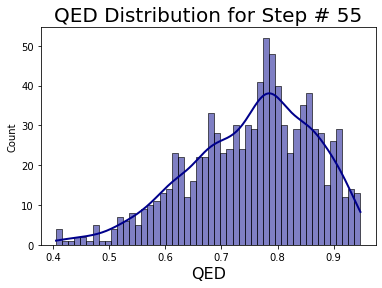

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.97e+00 65538.22  1.15e+04    5.41e+00     0.38     0.57   3.15e+00
 100   2.93e-01  6939.00  1.01e+02    6.84e-01     0.38     0.39   1.60e-02
 200   8.40e-02  5761.46  1.65e+01    5.74e-01     0.38     0.38   2.09e-03
 300   4.96e-02  5480.80  3.79e+00    5.48e-01     0.38     0.38   1.06e-03
 400   3.83e-02  5323.88 -2.50e-01    5.32e-01     0.38     0.38   8.21e-04
 500   3.31e-02  5199.72 -1.86e+00    5.20e-01     0.38     0.38   8.47e-04

---> After JKO Step: 56, F(ρ)=5.1985e+03 <---


***********************************************************************************
		JKO STEP 56 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

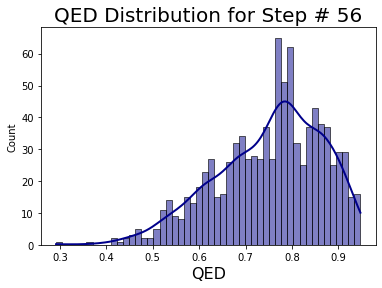

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.83e+00 76999.88  2.36e+04    5.34e+00     0.38     0.56   3.13e+00
 100   3.44e-01  7198.45  1.21e+02    7.08e-01     0.38     0.39   1.75e-02
 200   1.00e-01  5859.15  2.11e+01    5.84e-01     0.38     0.38   2.47e-03
 300   5.54e-02  5533.69  5.62e+00    5.53e-01     0.38     0.38   1.24e-03
 400   4.12e-02  5352.58  9.92e-01    5.35e-01     0.38     0.38   1.11e-03
 500   3.47e-02  5224.15 -1.03e+00    5.23e-01     0.38     0.38   8.88e-04

---> After JKO Step: 57, F(ρ)=5.2234e+03 <---


***********************************************************************************
		JKO STEP 57 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

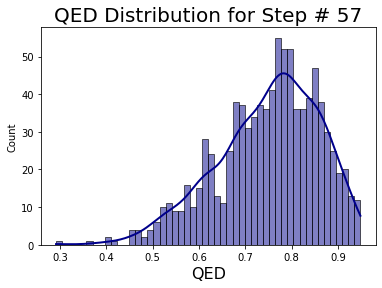

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.83e+00 84508.14  3.12e+04    5.33e+00     0.38     0.43   3.12e+00
 100   3.85e-01  7421.25  1.21e+02    7.30e-01     0.38     0.39   2.01e-02
 200   1.08e-01  5950.69  2.22e+01    5.93e-01     0.38     0.38   2.46e-03
 300   5.91e-02  5611.33  6.57e+00    5.60e-01     0.38     0.38   1.22e-03
 400   4.33e-02  5432.25  1.23e+00    5.43e-01     0.38     0.38   8.62e-04
 500   3.63e-02  5301.30 -1.02e+00    5.30e-01     0.38     0.38   6.47e-04

---> After JKO Step: 58, F(ρ)=5.3001e+03 <---


***********************************************************************************
		JKO STEP 58 End Summary:
Decoding embeddings to SMILES strings...(Took 0.16 seconds.)
Valid SMILES p

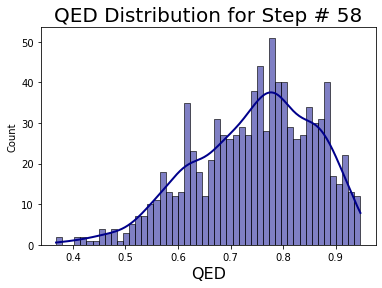

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.87e+00 65754.88  1.23e+04    5.35e+00     0.38     0.44   3.13e+00
 100   3.11e-01  7131.83  1.01e+02    7.03e-01     0.38     0.41   1.72e-02
 200   9.29e-02  5923.16  1.68e+01    5.91e-01     0.38     0.38   2.08e-03
 300   5.34e-02  5609.27  4.11e+00    5.61e-01     0.38     0.38   1.08e-03
 400   4.06e-02  5435.01 -1.07e-01    5.44e-01     0.38     0.38   9.88e-04
 500   3.52e-02  5306.10 -1.73e+00    5.31e-01     0.38     0.38   7.98e-04

---> After JKO Step: 59, F(ρ)=5.3056e+03 <---


***********************************************************************************
		JKO STEP 59 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

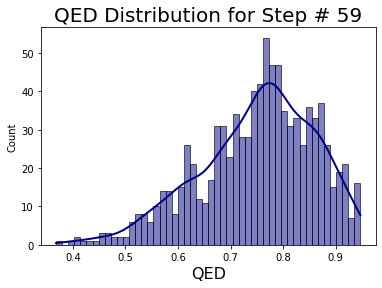

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.78e+00 64183.11  1.11e+04    5.31e+00     0.38     0.52   3.12e+00
 100   2.87e-01  7062.84  9.57e+01    6.97e-01     0.38     0.39   1.54e-02
 200   8.49e-02  5922.80  1.53e+01    5.91e-01     0.38     0.38   2.13e-03
 300   4.87e-02  5632.07  3.01e+00    5.63e-01     0.38     0.38   1.05e-03
 400   3.73e-02  5470.94 -4.90e-01    5.47e-01     0.38     0.38   1.11e-03
 500   3.21e-02  5341.22 -1.82e+00    5.34e-01     0.38     0.38   1.76e-03

---> After JKO Step: 60, F(ρ)=5.3397e+03 <---


***********************************************************************************
		JKO STEP 60 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

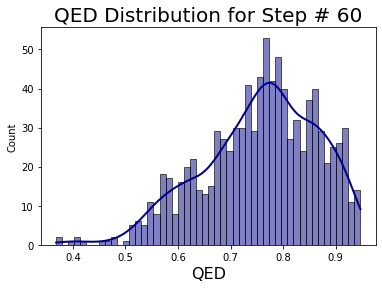

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.89e+00 81049.26  2.75e+04    5.35e+00     0.38     0.57   3.14e+00
 100   3.47e-01  7407.99  1.19e+02    7.29e-01     0.38     0.40   1.88e-02
 200   1.00e-01  6054.95  2.39e+01    6.03e-01     0.38     0.38   2.32e-03
 300   5.54e-02  5728.49  6.80e+00    5.72e-01     0.38     0.38   1.08e-03
 400   4.12e-02  5556.47  1.40e+00    5.56e-01     0.38     0.38   7.82e-04
 500   3.54e-02  5428.80 -8.94e-01    5.43e-01     0.38     0.38   7.06e-04

---> After JKO Step: 61, F(ρ)=5.4277e+03 <---


***********************************************************************************
		JKO STEP 61 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

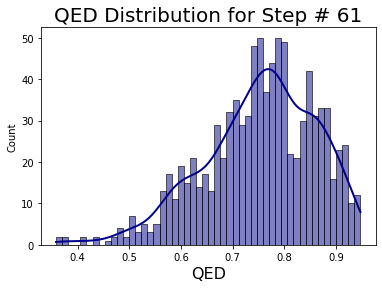

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.80e+00 53469.14  3.49e+02    5.31e+00     0.38     0.52   3.12e+00
 100   3.04e-01  7222.14  1.14e+02    7.11e-01     0.38     0.39   2.40e-02
 200   1.21e-01  6204.80  4.33e+01    6.16e-01     0.38     0.39   1.97e-03
 300   7.11e-02  5870.94  1.81e+01    5.85e-01     0.38     0.38   1.04e-03
 400   5.12e-02  5683.55  7.84e+00    5.68e-01     0.38     0.38   8.26e-04
 500   4.14e-02  5550.33  3.07e+00    5.55e-01     0.38     0.38   8.36e-04

---> After JKO Step: 62, F(ρ)=5.5489e+03 <---


***********************************************************************************
		JKO STEP 62 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

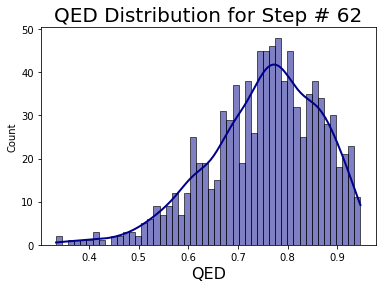

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.92e+00 61413.19  7.68e+03    5.37e+00     0.38     0.62   3.14e+00
 100   2.75e-01  7115.82  7.99e+01    7.04e-01     0.38     0.39   1.52e-02
 200   8.53e-02  6040.06  1.14e+01    6.03e-01     0.38     0.39   1.99e-03
 300   5.40e-02  5777.82  1.71e+00    5.78e-01     0.38     0.38   1.06e-03
 400   4.37e-02  5618.49 -1.11e+00    5.62e-01     0.38     0.38   1.18e-03
 500   3.91e-02  5493.72 -2.24e+00    5.50e-01     0.38     0.38   1.05e-03

---> After JKO Step: 63, F(ρ)=5.4927e+03 <---


***********************************************************************************
		JKO STEP 63 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

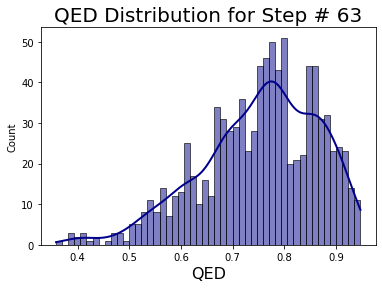

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.89e+00 62404.82  8.89e+03    5.35e+00     0.38     0.52   3.14e+00
 100   2.84e-01  7129.47  9.09e+01    7.04e-01     0.38     0.39   1.66e-02
 200   8.68e-02  6056.47  1.25e+01    6.04e-01     0.38     0.38   2.05e-03
 300   5.01e-02  5781.41  1.90e+00    5.78e-01     0.38     0.38   1.10e-03
 400   3.74e-02  5616.20 -1.12e+00    5.62e-01     0.38     0.38   8.10e-04
 500   3.18e-02  5478.75 -2.21e+00    5.48e-01     0.38     0.38   8.54e-04

---> After JKO Step: 64, F(ρ)=5.4777e+03 <---


***********************************************************************************
		JKO STEP 64 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

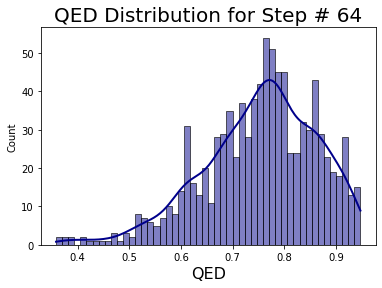

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.86e+00 75168.64  2.19e+04    5.33e+00     0.38     0.53   3.13e+00
 100   3.11e-01  7371.70  1.11e+02    7.26e-01     0.38     0.39   1.80e-02
 200   9.03e-02  6107.68  1.94e+01    6.09e-01     0.38     0.38   2.09e-03
 300   5.09e-02  5790.66  4.82e+00    5.79e-01     0.38     0.38   1.36e-03
 400   3.83e-02  5618.46  5.10e-01    5.62e-01     0.38     0.38   1.08e-03
 500   3.32e-02  5485.86 -1.23e+00    5.49e-01     0.38     0.38   9.73e-04

---> After JKO Step: 65, F(ρ)=5.4845e+03 <---


***********************************************************************************
		JKO STEP 65 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

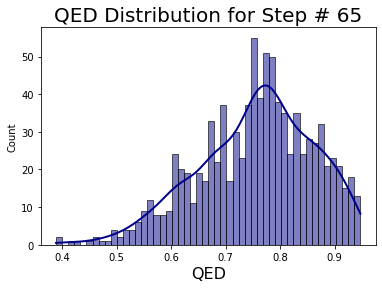

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.71e+00 83991.52  3.15e+04    5.25e+00     0.38     0.49   3.11e+00
 100   3.37e-01  7433.34  1.24e+02    7.31e-01     0.38     0.39   1.99e-02
 200   9.18e-02  6061.73  2.22e+01    6.04e-01     0.38     0.38   2.20e-03
 300   5.39e-02  5760.54  6.15e+00    5.75e-01     0.38     0.38   1.18e-03
 400   4.14e-02  5595.36  1.44e+00    5.59e-01     0.38     0.38   7.89e-04
 500   3.55e-02  5480.38 -4.60e-01    5.48e-01     0.38     0.38   9.73e-04

---> After JKO Step: 66, F(ρ)=5.4791e+03 <---


***********************************************************************************
		JKO STEP 66 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

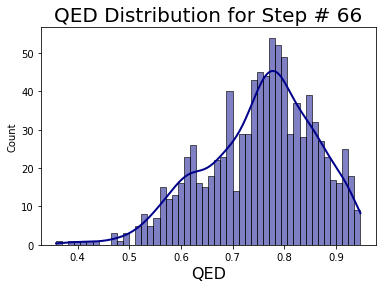

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.87e+00 66848.21  1.35e+04    5.33e+00     0.38     0.61   3.13e+00
 100   3.16e-01  7337.45  1.04e+02    7.23e-01     0.38     0.39   1.44e-02
 200   9.37e-02  6086.55  1.97e+01    6.07e-01     0.38     0.38   2.13e-03
 300   5.35e-02  5783.33  4.65e+00    5.78e-01     0.38     0.38   1.26e-03
 400   4.01e-02  5620.60  1.04e-01    5.62e-01     0.38     0.38   9.60e-04
 500   3.44e-02  5499.24 -1.65e+00    5.50e-01     0.38     0.38   9.48e-04

---> After JKO Step: 67, F(ρ)=5.4986e+03 <---


***********************************************************************************
		JKO STEP 67 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

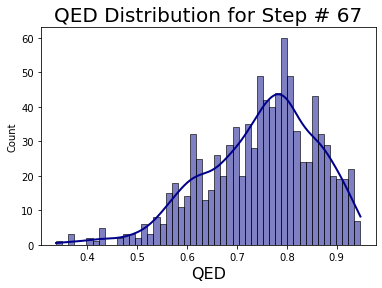

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.79e+00 80269.95  2.75e+04    5.28e+00     0.38     0.52   3.12e+00
 100   3.38e-01  7479.18  1.12e+02    7.37e-01     0.38     0.40   1.94e-02
 200   9.59e-02  6153.03  1.95e+01    6.13e-01     0.38     0.38   2.34e-03
 300   5.37e-02  5835.07  5.33e+00    5.83e-01     0.38     0.38   1.36e-03
 400   3.98e-02  5661.04  8.03e-01    5.66e-01     0.38     0.38   9.84e-04
 500   3.38e-02  5524.61 -1.04e+00    5.53e-01     0.38     0.38   1.00e-03

---> After JKO Step: 68, F(ρ)=5.5233e+03 <---


***********************************************************************************
		JKO STEP 68 End Summary:
Decoding embeddings to SMILES strings...(Took 0.16 seconds.)
Valid SMILES p

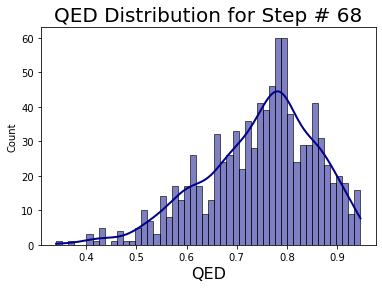

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.92e+00 86923.05  3.34e+04    5.35e+00     0.38     0.60   3.14e+00
 100   3.63e-01  7565.65  1.28e+02    7.44e-01     0.38     0.40   1.99e-02
 200   1.06e-01  6191.71  2.66e+01    6.17e-01     0.38     0.38   2.53e-03
 300   5.81e-02  5854.74  8.09e+00    5.85e-01     0.38     0.38   1.17e-03
 400   4.28e-02  5678.39  2.33e+00    5.68e-01     0.38     0.38   8.68e-04
 500   3.63e-02  5556.81 -7.73e-02    5.56e-01     0.38     0.38   1.11e-03

---> After JKO Step: 69, F(ρ)=5.5560e+03 <---


***********************************************************************************
		JKO STEP 69 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

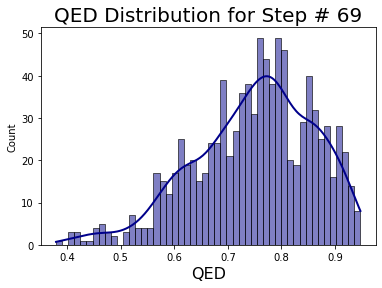

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.88e+00 73432.13  2.02e+04    5.32e+00     0.38     0.57   3.13e+00
 100   3.22e-01  7426.27  1.16e+02    7.31e-01     0.38     0.40   1.66e-02
 200   9.80e-02  6177.39  1.86e+01    6.16e-01     0.38     0.38   2.17e-03
 300   5.68e-02  5878.19  5.23e+00    5.87e-01     0.38     0.38   1.13e-03
 400   4.28e-02  5721.16  7.07e-01    5.72e-01     0.38     0.38   1.09e-03
 500   3.65e-02  5595.55 -1.21e+00    5.60e-01     0.38     0.38   8.62e-04

---> After JKO Step: 70, F(ρ)=5.5943e+03 <---


***********************************************************************************
		JKO STEP 70 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

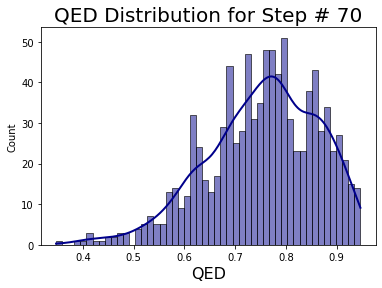

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.80e+00 57627.37  4.78e+03    5.28e+00     0.38     0.49   3.12e+00
 100   2.77e-01  7240.47  8.24e+01    7.16e-01     0.38     0.39   1.43e-02
 200   8.10e-02  6116.87  1.11e+01    6.11e-01     0.38     0.38   2.00e-03
 300   4.74e-02  5846.54  1.21e+00    5.85e-01     0.38     0.38   1.01e-03
 400   3.61e-02  5692.99 -1.56e+00    5.69e-01     0.38     0.38   1.49e-03
 500   3.13e-02  5566.02 -2.63e+00    5.57e-01     0.38     0.38   2.30e-03

---> After JKO Step: 71, F(ρ)=5.5647e+03 <---


***********************************************************************************
		JKO STEP 71 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

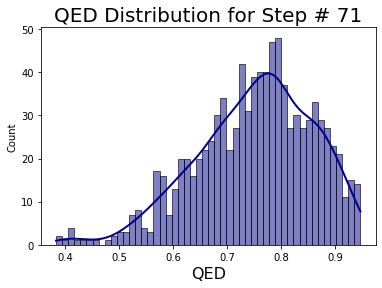

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.93e+00 54005.05  5.25e+02    5.35e+00     0.38     0.54   3.14e+00
 100   3.37e-01  7546.90  8.32e+01    7.46e-01     0.38     0.44   4.76e-02
 200   1.24e-01  6409.22  3.88e+01    6.37e-01     0.38     0.39   2.05e-03
 300   7.27e-02  6067.98  1.67e+01    6.05e-01     0.38     0.38   1.05e-03
 400   5.14e-02  5873.39  7.45e+00    5.87e-01     0.38     0.38   9.09e-04
 500   4.07e-02  5733.99  2.94e+00    5.73e-01     0.38     0.38   6.68e-04

---> After JKO Step: 72, F(ρ)=5.7329e+03 <---


***********************************************************************************
		JKO STEP 72 End Summary:
Decoding embeddings to SMILES strings...(Took 0.16 seconds.)
Valid SMILES p

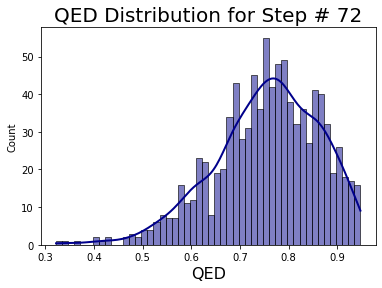

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.96e+00 65000.05  1.13e+04    5.37e+00     0.38     0.61   3.15e+00
 100   2.95e-01  7449.08  9.84e+01    7.35e-01     0.38     0.40   1.56e-02
 200   9.49e-02  6322.82  1.53e+01    6.31e-01     0.38     0.38   2.12e-03
 300   5.68e-02  6010.25  3.18e+00    6.01e-01     0.38     0.38   1.45e-03
 400   4.47e-02  5829.85 -2.11e-01    5.83e-01     0.38     0.38   1.02e-03
 500   4.00e-02  5696.77 -1.70e+00    5.70e-01     0.38     0.38   1.14e-03

---> After JKO Step: 73, F(ρ)=5.6952e+03 <---


***********************************************************************************
		JKO STEP 73 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

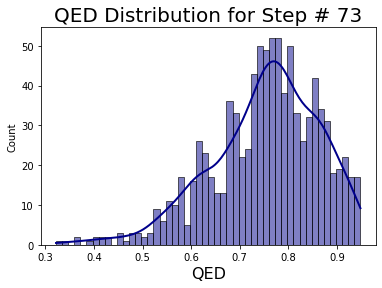

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.90e+00 65488.13  1.22e+04    5.33e+00     0.38     0.53   3.14e+00
 100   3.32e-01  7597.72  9.67e+01    7.50e-01     0.38     0.39   1.59e-02
 200   9.86e-02  6347.83  1.59e+01    6.33e-01     0.38     0.38   2.23e-03
 300   5.41e-02  6033.38  2.94e+00    6.03e-01     0.38     0.38   1.19e-03
 400   4.05e-02  5856.59 -1.04e+00    5.86e-01     0.38     0.38   9.15e-04
 500   3.51e-02  5715.84 -2.37e+00    5.72e-01     0.38     0.38   7.68e-04

---> After JKO Step: 74, F(ρ)=5.7148e+03 <---


***********************************************************************************
		JKO STEP 74 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

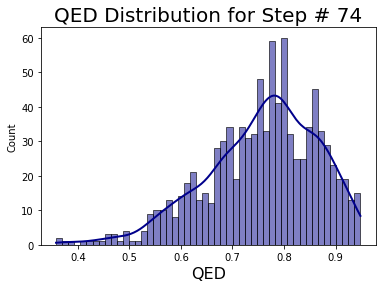

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.87e+00 66115.02  1.29e+04    5.32e+00     0.38     0.47   3.13e+00
 100   3.03e-01  7515.61  8.67e+01    7.43e-01     0.38     0.39   2.70e-02
 200   8.81e-02  6307.25  1.84e+01    6.29e-01     0.38     0.38   2.13e-03
 300   5.05e-02  6011.82  4.48e+00    6.01e-01     0.38     0.38   1.14e-03
 400   3.83e-02  5852.96 -1.73e-02    5.85e-01     0.38     0.38   9.38e-04
 500   3.29e-02  5736.85 -1.76e+00    5.74e-01     0.38     0.38   8.41e-04

---> After JKO Step: 75, F(ρ)=5.7357e+03 <---


***********************************************************************************
		JKO STEP 75 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

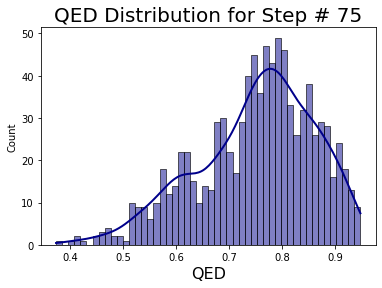

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.97e+00 76326.95  2.27e+04    5.36e+00     0.38     0.48   3.15e+00
 100   3.23e-01  7664.81  1.16e+02    7.55e-01     0.38     0.39   1.83e-02
 200   9.30e-02  6385.72  2.12e+01    6.36e-01     0.38     0.38   2.09e-03
 300   5.29e-02  6086.10  5.48e+00    6.08e-01     0.38     0.38   9.91e-04
 400   3.89e-02  5910.65  4.38e-01    5.91e-01     0.38     0.38   7.86e-04
 500   3.25e-02  5782.11 -1.64e+00    5.78e-01     0.38     0.38   6.20e-04

---> After JKO Step: 76, F(ρ)=5.7810e+03 <---


***********************************************************************************
		JKO STEP 76 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

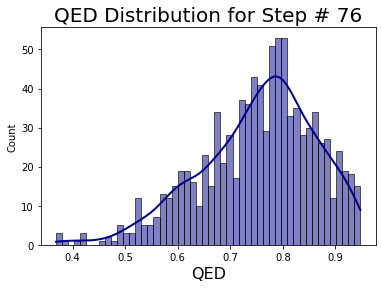

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.97e+00 65391.68  1.18e+04    5.36e+00     0.38     0.59   3.15e+00
 100   3.18e-01  7626.26  1.06e+02    7.52e-01     0.38     0.40   1.57e-02
 200   8.53e-02  6348.21  1.63e+01    6.33e-01     0.38     0.38   2.24e-03
 300   4.88e-02  6075.93  3.39e+00    6.07e-01     0.38     0.38   1.13e-03
 400   3.76e-02  5916.62 -1.12e-01    5.92e-01     0.38     0.38   9.04e-04
 500   3.30e-02  5786.70 -1.62e+00    5.79e-01     0.38     0.38   1.16e-03

---> After JKO Step: 77, F(ρ)=5.7851e+03 <---


***********************************************************************************
		JKO STEP 77 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

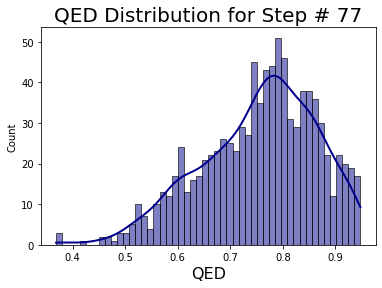

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.89e+00 86579.48  3.34e+04    5.32e+00     0.38     0.47   3.14e+00
 100   3.51e-01  7761.38  1.20e+02    7.64e-01     0.38     0.39   2.08e-02
 200   1.00e-01  6456.93  2.41e+01    6.43e-01     0.38     0.38   2.22e-03
 300   5.64e-02  6143.74  7.15e+00    6.14e-01     0.38     0.38   1.09e-03
 400   4.08e-02  5950.67  1.46e+00    5.95e-01     0.38     0.38   7.93e-04
 500   3.37e-02  5813.38 -8.57e-01    5.81e-01     0.38     0.38   8.40e-04

---> After JKO Step: 78, F(ρ)=5.8121e+03 <---


***********************************************************************************
		JKO STEP 78 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

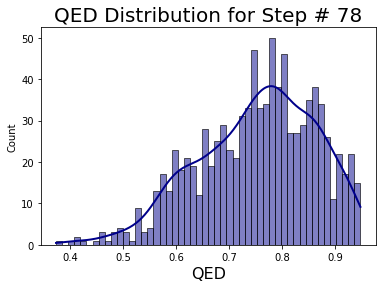

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.97e+00 67319.50  1.38e+04    5.35e+00     0.38     0.56   3.15e+00
 100   3.11e-01  7645.01  9.60e+01    7.55e-01     0.38     0.39   1.60e-02
 200   9.00e-02  6415.35  1.55e+01    6.40e-01     0.38     0.38   2.25e-03
 300   5.17e-02  6113.59  3.35e+00    6.11e-01     0.38     0.38   1.18e-03
 400   4.03e-02  5956.42 -2.31e-01    5.96e-01     0.38     0.38   8.58e-04
 500   3.51e-02  5833.24 -1.69e+00    5.83e-01     0.38     0.38   1.11e-03

---> After JKO Step: 79, F(ρ)=5.8318e+03 <---


***********************************************************************************
		JKO STEP 79 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

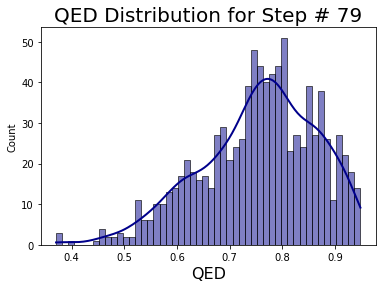

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.89e+00 56656.93  3.64e+03    5.30e+00     0.38     0.42   3.14e+00
 100   2.53e-01  7420.67  7.75e+01    7.34e-01     0.38     0.39   1.37e-02
 200   7.45e-02  6381.62  1.10e+01    6.37e-01     0.38     0.38   1.98e-03
 300   4.66e-02  6146.60  1.02e+00    6.15e-01     0.38     0.38   1.07e-03
 400   3.65e-02  5993.30 -1.76e+00    6.00e-01     0.38     0.38   2.05e-03
 500   3.14e-02  5857.44 -2.69e+00    5.86e-01     0.38     0.38   1.98e-03

---> After JKO Step: 80, F(ρ)=5.8562e+03 <---


***********************************************************************************
		JKO STEP 80 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

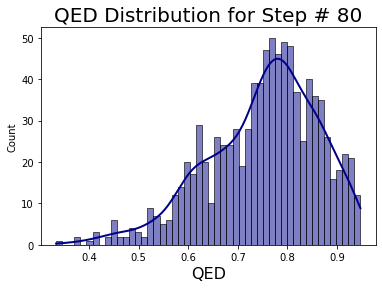

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.00e+01 65666.23  1.20e+04    5.37e+00     0.38     0.45   3.16e+00
 100   2.80e-01  7561.91  9.38e+01    7.47e-01     0.38     0.39   1.65e-02
 200   7.92e-02  6450.97  1.42e+01    6.44e-01     0.38     0.38   2.19e-03
 300   4.50e-02  6179.71  2.56e+00    6.18e-01     0.38     0.38   9.86e-04
 400   3.43e-02  6025.30 -8.65e-01    6.03e-01     0.38     0.38   7.84e-04
 500   2.94e-02  5900.69 -2.25e+00    5.90e-01     0.38     0.38   8.29e-04

---> After JKO Step: 81, F(ρ)=5.8996e+03 <---


***********************************************************************************
		JKO STEP 81 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

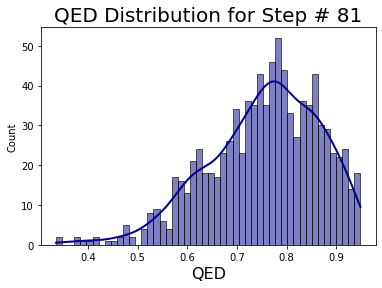

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.00e+01 57174.14  3.54e+03    5.36e+00     0.38     0.57   3.16e+00
 100   2.61e-01  7508.30  7.82e+01    7.43e-01     0.38     0.39   1.40e-02
 200   8.02e-02  6476.84  1.22e+01    6.46e-01     0.38     0.38   2.10e-03
 300   4.62e-02  6192.71  1.93e+00    6.19e-01     0.38     0.38   1.24e-03
 400   3.53e-02  6023.87 -1.13e+00    6.03e-01     0.38     0.38   9.40e-04
 500   3.12e-02  5893.37 -2.14e+00    5.90e-01     0.38     0.38   1.04e-03

---> After JKO Step: 82, F(ρ)=5.8922e+03 <---


***********************************************************************************
		JKO STEP 82 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

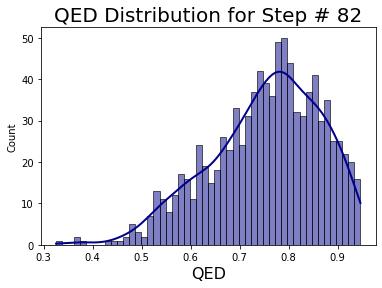

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.98e+00 63406.70  1.01e+04    5.33e+00     0.38     0.57   3.15e+00
 100   2.86e-01  7566.96  9.97e+01    7.47e-01     0.38     0.39   1.50e-02
 200   8.22e-02  6435.83  1.75e+01    6.42e-01     0.38     0.38   2.31e-03
 300   4.80e-02  6159.41  4.29e+00    6.16e-01     0.38     0.38   1.14e-03
 400   3.70e-02  5997.69  3.97e-01    6.00e-01     0.38     0.38   1.36e-03
 500   3.23e-02  5872.72 -1.43e+00    5.87e-01     0.38     0.38   1.22e-03

---> After JKO Step: 83, F(ρ)=5.8720e+03 <---


***********************************************************************************
		JKO STEP 83 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

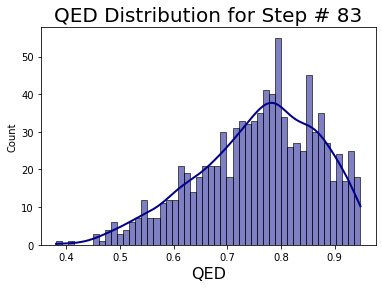

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.02e+01 81034.42  2.70e+04    5.41e+00     0.38     0.55   3.18e+00
 100   3.16e-01  7736.46  1.18e+02    7.62e-01     0.38     0.39   2.04e-02
 200   9.17e-02  6469.26  1.96e+01    6.45e-01     0.38     0.38   2.01e-03
 300   5.27e-02  6179.63  4.47e+00    6.18e-01     0.38     0.37   9.67e-04
 400   3.97e-02  6024.04  8.30e-02    6.02e-01     0.38     0.38   7.23e-04
 500   3.42e-02  5912.08 -1.62e+00    5.91e-01     0.38     0.38   7.87e-04

---> After JKO Step: 84, F(ρ)=5.9115e+03 <---


***********************************************************************************
		JKO STEP 84 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

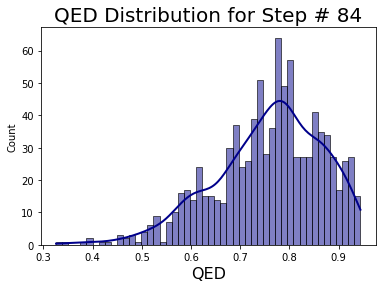

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 77700.37  2.38e+04    5.39e+00     0.38     0.59   3.17e+00
 100   3.04e-01  7718.71  1.17e+02    7.60e-01     0.38     0.39   1.93e-02
 200   8.77e-02  6518.52  2.10e+01    6.50e-01     0.38     0.38   2.00e-03
 300   5.09e-02  6231.20  5.44e+00    6.23e-01     0.38     0.38   1.06e-03
 400   3.77e-02  6063.87  7.04e-01    6.06e-01     0.38     0.38   6.82e-04
 500   3.17e-02  5942.90 -1.25e+00    5.94e-01     0.38     0.38   9.10e-04

---> After JKO Step: 85, F(ρ)=5.9417e+03 <---


***********************************************************************************
		JKO STEP 85 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

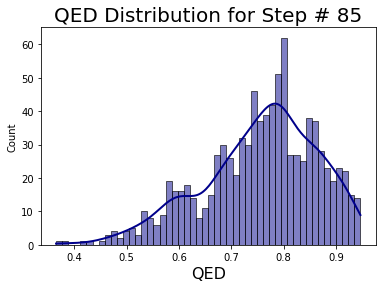

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.95e+00 59586.60  6.67e+03    5.29e+00     0.38     0.54   3.14e+00
 100   2.59e-01  7462.56  8.61e+01    7.38e-01     0.38     0.38   1.31e-02
 200   7.83e-02  6467.81  1.25e+01    6.46e-01     0.38     0.38   1.95e-03
 300   4.74e-02  6223.82  1.78e+00    6.22e-01     0.38     0.37   9.73e-04
 400   3.72e-02  6067.08 -1.19e+00    6.07e-01     0.38     0.37   7.31e-04
 500   3.30e-02  5944.76 -2.34e+00    5.95e-01     0.38     0.37   7.24e-04

---> After JKO Step: 86, F(ρ)=5.9438e+03 <---


***********************************************************************************
		JKO STEP 86 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

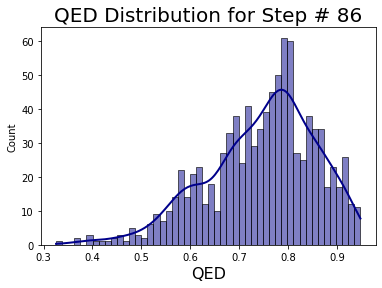

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 64707.75  1.11e+04    5.36e+00     0.37     0.58   3.17e+00
 100   2.97e-01  7662.96  1.02e+02    7.56e-01     0.37     0.39   1.57e-02
 200   8.70e-02  6531.77  1.57e+01    6.52e-01     0.37     0.38   2.01e-03
 300   4.97e-02  6249.62  3.54e+00    6.25e-01     0.37     0.37   1.21e-03
 400   3.69e-02  6079.79 -1.85e-01    6.08e-01     0.37     0.37   7.93e-04
 500   3.11e-02  5945.10 -1.78e+00    5.95e-01     0.37     0.37   1.19e-03

---> After JKO Step: 87, F(ρ)=5.9434e+03 <---


***********************************************************************************
		JKO STEP 87 End Summary:
Decoding embeddings to SMILES strings...(Took 0.16 seconds.)
Valid SMILES p

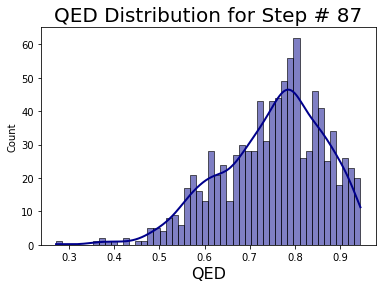

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 61247.39  7.43e+03    5.38e+00     0.37     0.58   3.17e+00
 100   2.81e-01  7595.48  9.64e+01    7.50e-01     0.37     0.38   1.50e-02
 200   8.12e-02  6514.64  1.46e+01    6.50e-01     0.37     0.37   2.11e-03
 300   4.76e-02  6253.37  2.65e+00    6.25e-01     0.37     0.37   1.05e-03
 400   3.66e-02  6100.33 -8.25e-01    6.10e-01     0.37     0.37   8.76e-04
 500   3.19e-02  5975.58 -2.18e+00    5.98e-01     0.37     0.37   7.93e-04

---> After JKO Step: 88, F(ρ)=5.9746e+03 <---


***********************************************************************************
		JKO STEP 88 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

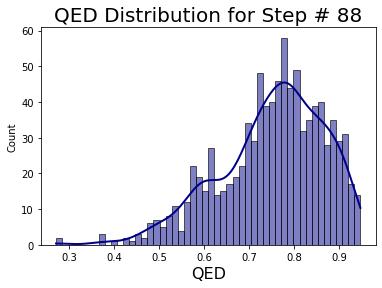

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 57083.26  3.55e+03    5.35e+00     0.37     0.43   3.17e+00
 100   2.73e-01  7570.00  7.72e+01    7.49e-01     0.37     0.38   1.53e-02
 200   7.81e-02  6502.58  1.06e+01    6.49e-01     0.37     0.37   1.96e-03
 300   4.60e-02  6247.94  1.42e+00    6.25e-01     0.37     0.37   1.15e-03
 400   3.57e-02  6092.31 -1.42e+00    6.09e-01     0.37     0.37   8.83e-04
 500   3.13e-02  5976.11 -2.61e+00    5.98e-01     0.37     0.37   1.24e-03

---> After JKO Step: 89, F(ρ)=5.9753e+03 <---


***********************************************************************************
		JKO STEP 89 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

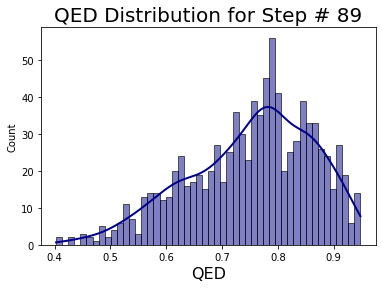

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.00e+01 70426.91  1.72e+04    5.32e+00     0.37     0.52   3.15e+00
 100   2.96e-01  7738.10  1.11e+02    7.63e-01     0.37     0.38   1.62e-02
 200   8.98e-02  6583.39  2.08e+01    6.56e-01     0.37     0.37   2.19e-03
 300   5.24e-02  6296.46  5.51e+00    6.29e-01     0.37     0.37   1.05e-03
 400   3.95e-02  6139.52  7.69e-01    6.14e-01     0.37     0.37   8.19e-04
 500   3.39e-02  6012.75 -1.11e+00    6.01e-01     0.37     0.37   8.80e-04

---> After JKO Step: 90, F(ρ)=6.0111e+03 <---


***********************************************************************************
		JKO STEP 90 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

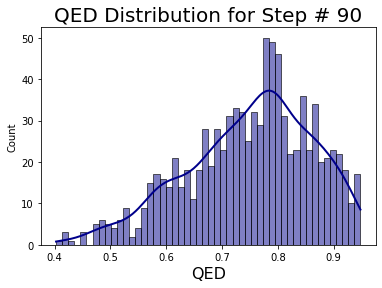

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.00e+01 70199.69  1.68e+04    5.34e+00     0.37     0.56   3.16e+00
 100   3.18e-01  7815.38  1.09e+02    7.71e-01     0.37     0.37   1.62e-02
 200   9.20e-02  6562.75  2.11e+01    6.54e-01     0.37     0.37   2.24e-03
 300   5.32e-02  6270.83  5.54e+00    6.27e-01     0.37     0.37   1.33e-03
 400   4.11e-02  6104.54  9.92e-01    6.10e-01     0.37     0.37   1.29e-03
 500   3.62e-02  5977.52 -8.43e-01    5.98e-01     0.37     0.37   1.09e-03

---> After JKO Step: 91, F(ρ)=5.9768e+03 <---


***********************************************************************************
		JKO STEP 91 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

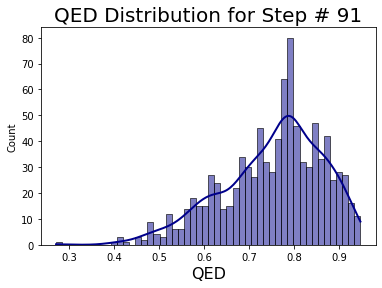

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   9.94e+00 71349.06  1.86e+04    5.28e+00     0.37     0.48   3.14e+00
 100   3.21e-01  7878.36  1.07e+02    7.77e-01     0.37     0.39   1.60e-02
 200   9.41e-02  6620.43  1.97e+01    6.60e-01     0.37     0.38   2.27e-03
 300   5.44e-02  6322.87  5.20e+00    6.32e-01     0.37     0.37   1.08e-03
 400   4.12e-02  6153.11  5.44e-01    6.15e-01     0.37     0.37   8.65e-04
 500   3.53e-02  6018.99 -1.37e+00    6.02e-01     0.37     0.37   7.27e-04

---> After JKO Step: 92, F(ρ)=6.0178e+03 <---


***********************************************************************************
		JKO STEP 92 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

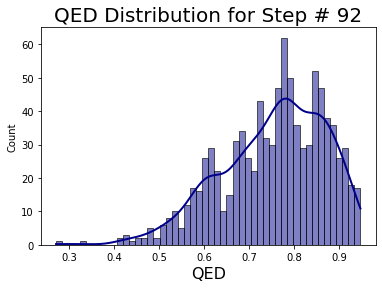

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.02e+01 59428.33  5.44e+03    5.40e+00     0.37     0.47   3.18e+00
 100   2.76e-01  7660.63  9.30e+01    7.57e-01     0.37     0.39   1.77e-02
 200   8.58e-02  6593.86  1.37e+01    6.58e-01     0.37     0.38   2.03e-03
 300   4.90e-02  6309.79  2.30e+00    6.31e-01     0.37     0.37   1.09e-03
 400   3.74e-02  6147.93 -1.05e+00    6.15e-01     0.37     0.37   8.79e-04
 500   3.25e-02  6021.52 -2.32e+00    6.02e-01     0.37     0.37   8.02e-04

---> After JKO Step: 93, F(ρ)=6.0206e+03 <---


***********************************************************************************
		JKO STEP 93 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

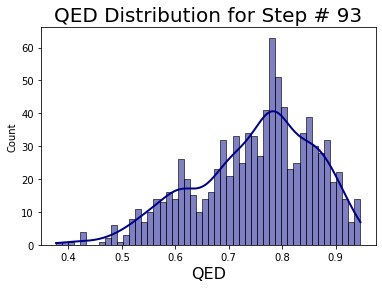

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 87578.88  3.38e+04    5.38e+00     0.37     0.54   3.17e+00
 100   3.39e-01  7977.80  1.23e+02    7.85e-01     0.37     0.39   1.95e-02
 200   9.78e-02  6665.96  2.47e+01    6.64e-01     0.37     0.38   2.25e-03
 300   5.43e-02  6350.04  7.60e+00    6.34e-01     0.37     0.37   1.20e-03
 400   3.95e-02  6177.39  1.99e+00    6.18e-01     0.37     0.37   8.16e-04
 500   3.30e-02  6052.33 -3.98e-01    6.05e-01     0.37     0.37   8.90e-04

---> After JKO Step: 94, F(ρ)=6.0513e+03 <---


***********************************************************************************
		JKO STEP 94 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

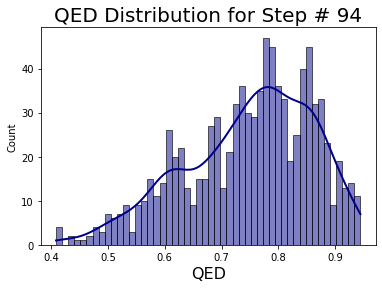

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 78312.94  2.46e+04    5.37e+00     0.37     0.58   3.17e+00
 100   3.53e-01  8023.38  1.20e+02    7.90e-01     0.37     0.38   1.84e-02
 200   1.08e-01  6696.99  2.41e+01    6.67e-01     0.37     0.37   2.38e-03
 300   6.09e-02  6381.15  6.59e+00    6.37e-01     0.37     0.37   1.09e-03
 400   4.49e-02  6215.17  1.04e+00    6.21e-01     0.37     0.37   7.71e-04
 500   3.79e-02  6089.27 -1.18e+00    6.09e-01     0.37     0.37   6.97e-04

---> After JKO Step: 95, F(ρ)=6.0884e+03 <---


***********************************************************************************
		JKO STEP 95 End Summary:
Decoding embeddings to SMILES strings...(Took 0.29 seconds.)
Valid SMILES p

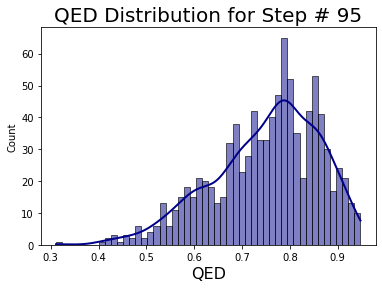

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 63153.61  9.85e+03    5.33e+00     0.37     0.49   3.16e+00
 100   2.91e-01  7781.83  9.82e+01    7.68e-01     0.37     0.38   1.50e-02
 200   8.87e-02  6664.39  1.59e+01    6.65e-01     0.37     0.37   2.11e-03
 300   5.26e-02  6385.53  3.30e+00    6.38e-01     0.37     0.37   1.06e-03
 400   4.07e-02  6226.33 -5.13e-01    6.23e-01     0.37     0.37   1.49e-03
 500   3.60e-02  6104.81 -1.98e+00    6.11e-01     0.37     0.37   9.18e-04

---> After JKO Step: 96, F(ρ)=6.1038e+03 <---


***********************************************************************************
		JKO STEP 96 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

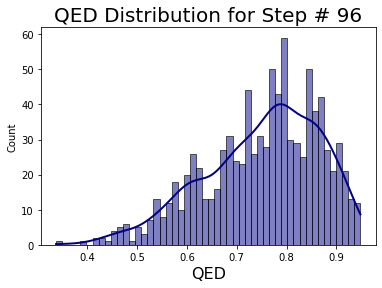

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 64503.79  1.12e+04    5.33e+00     0.37     0.44   3.16e+00
 100   2.96e-01  7882.58  9.71e+01    7.79e-01     0.37     0.39   1.60e-02
 200   8.27e-02  6681.74  1.45e+01    6.67e-01     0.37     0.37   2.11e-03
 300   4.78e-02  6394.80  2.75e+00    6.39e-01     0.37     0.37   1.12e-03
 400   3.65e-02  6224.66 -6.86e-01    6.23e-01     0.37     0.37   8.70e-04
 500   3.18e-02  6094.84 -2.05e+00    6.10e-01     0.37     0.37   1.15e-03

---> After JKO Step: 97, F(ρ)=6.0942e+03 <---


***********************************************************************************
		JKO STEP 97 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

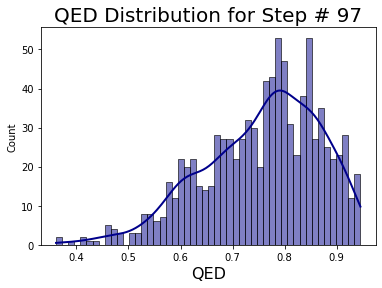

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 60497.24  7.05e+03    5.34e+00     0.37     0.48   3.17e+00
 100   2.55e-01  7612.57  8.93e+01    7.52e-01     0.37     0.38   1.51e-02
 200   7.57e-02  6586.60  1.27e+01    6.57e-01     0.37     0.37   1.97e-03
 300   4.54e-02  6324.05  2.07e+00    6.32e-01     0.37     0.37   1.16e-03
 400   3.47e-02  6151.33 -9.31e-01    6.15e-01     0.37     0.37   1.47e-03
 500   3.03e-02  6024.82 -2.04e+00    6.03e-01     0.37     0.37   1.41e-03

---> After JKO Step: 98, F(ρ)=6.0241e+03 <---


***********************************************************************************
		JKO STEP 98 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES p

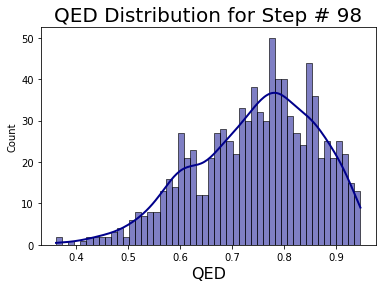

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 111694.56  5.84e+04    5.33e+00     0.37     0.62   3.16e+00
 100   3.96e-01  8201.08  1.47e+02    8.05e-01     0.37     0.40   2.25e-02
 200   1.11e-01  6765.19  3.48e+01    6.73e-01     0.37     0.37   2.45e-03
 300   6.01e-02  6408.30  1.14e+01    6.40e-01     0.37     0.37   1.26e-03
 400   4.36e-02  6225.42  4.17e+00    6.22e-01     0.37     0.37   9.49e-04
 500   3.60e-02  6087.45  1.05e+00    6.09e-01     0.37     0.37   7.75e-04

---> After JKO Step: 99, F(ρ)=6.0863e+03 <---


***********************************************************************************
		JKO STEP 99 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES 

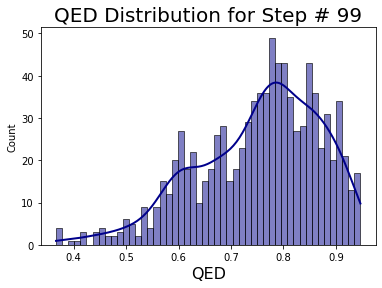

***********************************************************************************

--------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       𝒱(ρ)   + SD(ρ,β)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------------------------------------------------
   0   1.01e+01 54174.85  5.34e+02    5.36e+00     0.37     0.57   3.17e+00
 100   2.59e-01  7554.00  6.64e+01    7.49e-01     0.37     0.37   1.53e-02
 200   8.16e-02  6597.85  9.42e+00    6.59e-01     0.37     0.37   1.94e-03
 300   4.76e-02  6336.01  8.00e-01    6.34e-01     0.37     0.37   1.12e-03
 400   3.70e-02  6183.27 -1.75e+00    6.19e-01     0.37     0.37   1.08e-03
 500   3.28e-02  6064.43 -2.73e+00    6.07e-01     0.37     0.37   1.20e-03

---> After JKO Step: 100, F(ρ)=6.0635e+03 <---


***********************************************************************************
		JKO STEP 100 End Summary:
Decoding embeddings to SMILES strings...(Took 0.15 seconds.)
Valid SMILES

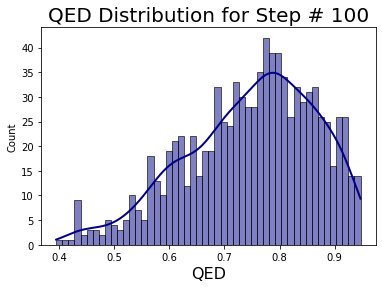

***********************************************************************************



tensor([[ 0.0013,  0.0008, -0.0159,  ...,  0.0106, -0.0065,  0.0016],
        [ 0.0096, -0.0029,  0.0060,  ...,  0.0025, -0.0090,  0.0015],
        [ 0.0012,  0.0025,  0.0053,  ..., -0.0078, -0.0137, -0.0021],
        ...,
        [-0.0133,  0.0163, -0.0172,  ..., -0.0082,  0.0141,  0.0065],
        [ 0.0123, -0.0002,  0.0056,  ..., -0.0059, -0.0125, -0.0059],
        [ 0.0136, -0.0182, -0.0155,  ..., -0.0043, -0.0077, -0.0124]],
       device='cuda:0')

In [9]:
# Run gradient flow
jko_steps = 100
grad_flow = GradFlow(X=embeddings_0, F=functional_sum, τ=1e-4, lr=1e-3, opt_iters=500,
                     callbacks=mol_callback, warmopt=False)
grad_flow.flow(steps=jko_steps)

## 4. Display animation of histogram trajectory

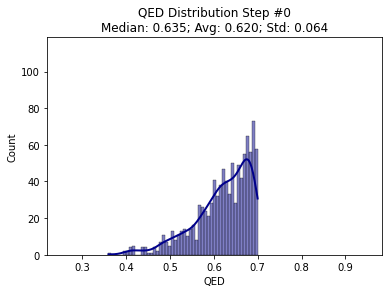

In [10]:
data = torch.load('../molecule_pde_files/flow.pt')
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    sns.histplot(data['qed_dist'][i], ax=ax, kde=True, bins=50,
                 color='darkblue', line_kws={'linewidth': 2})
    ax.set_xlabel('QED')
    title = f'QED Distribution Step #{i}\n'
    title += f'Median: {data["qed_median"][i]:.3f}; '
    title += f'Avg: {data["qed_avg"][i]:.3f}; '
    title += f'Std: {data["qed_std"][i]:.3f}'
    ax.set_title(title)

ani = animation.FuncAnimation(fig, animate, frames=jko_steps+1, interval=400, repeat=True)
display(HTML(ani.to_jshtml()))